<a href="https://colab.research.google.com/github/Aaricis/Hung-yi-Lee-ML2021/blob/main/ML2022Spring_HW1_Boss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2022-spring@googlegroups.com

# Simple Baseline
- 直接运行Sample Code
  
  Score: 1.89565
  Private score: 1.91281

# Strong Baseline

- 特征筛选：
  
  feat_idx = [38, 39, 40, 41, 53, 54, 55, 56, 57, 69, 70, 71, 72, 73, 85, 86, 87, 88, 89, 101, 102, 103, 104, 105]
- ReLU改为`nn.LeakyReLU(negative_slope=0.01)`
- 数据归一化：原始数据作normalization之后再输入模型
```python
# normalization
x_min, x_max = x_train.min(axis=0), x_train.max(axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_valid = (x_valid - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)
```

**加上这三个措施就直接过Strong Baseline了**

Score: 0.86740
Private score: 0.90411

# Boss Baseline

在Strong Baseline基础上进行了大量的调参工作：学习率、优化器、batchsize、模型结构，都没有得到更好的结果。已经快要放弃了，死马当活马医尝试换了`seed`，发现结果波动非常大，此时依然没有突破Boss Baseline。这个做法启发了我，我使用三个不同的seed分别跑出结果，把3份`.csv`文档使用平均法进行Ensemble再提交，就突破Boss Baseline了😊。

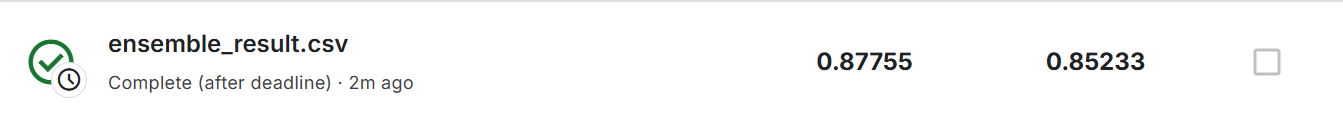




# Download data
If the Google Drive links below do not work, you can download data from [Kaggle](https://www.kaggle.com/t/a3ebd5b5542f0f55e828d4f00de8e59a), and upload data manually to the workspace.

In [67]:
!gdown --id '1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS' --output covid.train.csv
!gdown --id '1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg' --output covid.test.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS
To: /content/covid.train.csv
100% 2.49M/2.49M [00:00<00:00, 103MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg
To: /content/covid.test.csv
100% 993k/993k [00:00<00:00, 130MB/s]


# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# Feature Analyze

In [69]:
# 读取数据
train_data = pd.read_csv('./covid.train.csv')
test_data = pd.read_csv('./covid.test.csv')

In [70]:
# 数据规模
print("Train: {:4d}".format(len(train_data)))
print("Test: {:4d}".format(len(test_data)))

Train: 2699
Test: 1078


In [71]:
# feature名稱、型別、空值
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2699 entries, 0 to 2698
Columns: 118 entries, id to tested_positive.4
dtypes: float64(80), int64(38)
memory usage: 2.4 MB


In [72]:
# 显示所有列
pd.set_option("display.max_columns", None)

# 显示所有行
pd.set_option("display.max_rows", None)

# 使用均值、标准差、最小值、最大值、分位数来比较训练集和测试集的分布情况
train_data.iloc[:, 38:].describe()


,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,worried_finances.2,tested_positive.2,cli.3,ili.3,hh_cmnty_cli.3,nohh_cmnty_cli.3,wearing_mask.3,travel_outside_state.3,work_outside_home.3,shop.3,restaurant.3,spent_time.3,large_event.3,public_transit.3,anxious.3,depressed.3,worried_finances.3,tested_positive.3,cli.4,ili.4,hh_cmnty_cli.4,nohh_cmnty_cli.4,wearing_mask.4,travel_outside_state.4,work_outside_home.4,shop.4,restaurant.4,spent_time.4,large_event.4,public_transit.4,anxious.4,depressed.4,worried_finances.4,tested_positive.4
count,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000
mean,0.929055,0.942800,15.139448,11.361719,51.846616,15.864961,33.084390,66.354204,34.673977,44.815813,19.923754,4.661624,11.895154,9.970230,34.827581,9.599680,0.935966,0.950077,15.227049,11.451188,51.619087,15.889132,33.063299,66.396445,34.721939,44.825616,19.951696,4.669599,11.914578,9.978714,34.827521,9.654780,0.943030,0.957383,15.314802,11.541271,51.403169,15.911573,33.045662,66.431178,34.761696,44.833368,19.978151,4.678452,11.933770,9.985709,34.825931,9.712005,0.950079,0.964578,15.407295,11.635973,51.207340,15.929914,33.030236,66.454623,34.794829,44.839698,19.998701,4.686318,11.947655,9.990279,34.825181,9.769782,0.956898,0.971633,15.504531,11.734277,51.024843,15.947624,33.019169,66.472173,34.825731,44.847642,20.021135,4.694451,11.963645,9.993727,34.830569,9.819307
std,0.500590,0.506881,8.188440,7.635697,16.041680,4.587564,3.797806,2.579895,4.250106,3.732372,3.618681,2.109780,2.222707,1.562551,3.583642,6.313452,0.504705,0.511091,8.257488,7.698325,15.770092,4.581852,3.803542,2.523895,4.193057,3.711097,3.578342,2.114107,2.234357,1.569038,3.588109,6.343652,0.509706,0.516230,8.323593,7.758770,15.510964,4.575176,3.810626,2.486977,4.144595,3.691246,3.541958,2.118587,2.247609,1.578923,3.597144,6.382100,0.514304,0.521070,8.390694,7.820468,15.268909,4.563894,3.819355,2.464644,4.101623,3.673111,3.507355,2.124118,2.258737,1.587661,3.604537,6.414908,0.518864,0.525888,8.454688,7.879511,15.045576,4.556996,3.829507,2.453508,4.068668,3.658667,3.480065,2.130388,2.270315,1.599229,3.613087,6.431729
min,0.212642,0.222141,5.980392,3.632015,18.873783,4.481132,24.560314,56.155790,21.160206,32.965636,9.144539,1.471465,7.347204,6.184896,24.591933,0.344828,0.212642,0.222141,5.980392,3.632015,18.873783,4.481132,24.560314,56.857707,21.684109,33.814227,9.144539,1.471465,7.347204,6.184896,24.591933,0.344828,0.212642,0.222141,5.980392,3.632015,18.873783,4.481132,24.560314,57.583599,21.930253,34.374998,9.369684,1.471465,7.347204,6.184

In [73]:
test_data.iloc[:, 38:].describe()

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,worried_finances.2,tested_positive.2,cli.3,ili.3,hh_cmnty_cli.3,nohh_cmnty_cli.3,wearing_mask.3,travel_outside_state.3,work_outside_home.3,shop.3,restaurant.3,spent_time.3,large_event.3,public_transit.3,anxious.3,depressed.3,worried_finances.3,tested_positive.3,cli.4,ili.4,hh_cmnty_cli.4,nohh_cmnty_cli.4,wearing_mask.4,travel_outside_state.4,work_outside_home.4,shop.4,restaurant.4,spent_time.4,large_event.4,public_transit.4,anxious.4,depressed.4,worried_finances.4
count,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000
mean,1.696624,1.735844,24.199464,19.418639,62.303215,14.565486,33.453409,65.310193,32.729616,43.746663,21.163742,4.614435,13.654282,11.075322,36.205691,14.754489,1.722855,1.762404,24.408750,19.601431,62.454952,14.515021,33.403701,65.212338,32.641161,43.784392,21.169890,4.605689,13.677635,11.115904,36.222246,14.905016,1.742170,1.782666,24.595882,19.771379,62.618384,14.445920,33.332199,65.101086,32.557518,43.712211,21.122220,4.594429,13.677043,11.133904,36.243696,15.052264,1.761680,1.802832,24.750801,19.921402,62.766227,14.413096,33.305279,65.087104,32.543264,43.594538,21.038771,4.591781,13.699767,11.157240,36.261111,15.168567,1.782039,1.824836,24.907033,20.059830,62.911650,14.388272,33.340883,65.068654,32.509515,43.492111,20.997452,4.588530,13.702900,11.142185,36.293656
std,1.059577,1.085970,9.394812,8.600490,13.174267,4.032675,4.144369,3.347384,4.334732,4.383067,4.338083,2.137514,2.025991,1.649531,3.388994,7.245000,1.092477,1.120352,9.587578,8.777890,13.148807,4.047851,4.144462,3.331302,4.356618,4.483673,4.405854,2.152544,2.051534,1.657571,3.382697,7.464604,1.111840,1.139825,9.744482,8.926377,13.117979,4.036199,4.147313,3.409291,4.401499,4.528051,4.426731,2.156811,2.047635,1.659307,3.392889,7.643282,1.130832,1.158424,9.863534,9.035893,13.100880,4.029173,4.177105,3.526735,4.459165,4.529272,4.414385,2.155324,2.041950,1.648985,3.394107,7.728694,1.151991,1.181697,9.980101,9.138620,13.082389,4.034543,4.159798,3.629110,4.509875,4.575007,4.417758,2.151651,2.046716,1.660211,3.399338
min,0.347450,0.346714,8.056648,5.018598,24.458825,5.854770,19.787537,50.364178,17.010620,28.300442,9.787555,1.734478,8.688044,6.729862,27.793666,2.725120,0.332812,0.372838,8.377877,5.253311,25.348308,5.389283,18.823910,50.780876,17.100464,27.970042,9.935721,1.694564,8.636382,6.552757,26.463961,2.441862,0.338909,0.379024,8.386532,5.444632,26.090610,5.109449,18.481661,50.496345,17.299276,27.889816,9.798319,1.559648,8.923437,5.160161,27.093808,2.693210,0.408942,0.44711

In [74]:
# 判断feature跟target之间的相关程度
corr = train_data.iloc[:, 38:].corr().iloc[-1]
corr

,tested_positive.4
cli,0.852766
ili,0.852934
hh_cmnty_cli,0.880777
nohh_cmnty_cli,0.873750
wearing_mask,-0.135891
travel_outside_state,-0.064729
work_outside_home,0.572663
shop,-0.290625
restaurant,-0.048994
spent_time,0.078154


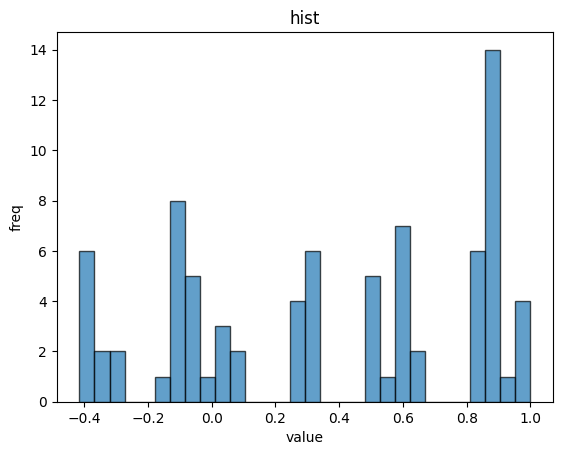

In [75]:
import matplotlib.pyplot as plt

# 使用Pandas自带的绘图方法
corr.plot.hist(bins=30, edgecolor='black', alpha=0.7)
plt.title("hist")
plt.xlabel("value")
plt.ylabel("freq")
plt.show()

In [76]:
features = corr[abs(corr) > 0.8]
features_col = features.index.to_list()[:-1]
features_id = [train_data.columns.to_list().index(i) for i in features_col]

print(features)
print(len(features))
print("\nfeatures' id:", features_id)

cli                  0.852766
ili                  0.852934
hh_cmnty_cli         0.880777
nohh_cmnty_cli       0.873750
tested_positive      0.935388
cli.1                0.855321
ili.1                0.855774
hh_cmnty_cli.1       0.886122
nohh_cmnty_cli.1     0.879162
tested_positive.1    0.953333
cli.2                0.856519
ili.2                0.857181
hh_cmnty_cli.2       0.890802
nohh_cmnty_cli.2     0.883926
tested_positive.2    0.969593
cli.3                0.859617
ili.3                0.860141
hh_cmnty_cli.3       0.894936
nohh_cmnty_cli.3     0.887985
tested_positive.3    0.985357
cli.4                0.862584
ili.4                0.862821
hh_cmnty_cli.4       0.898437
nohh_cmnty_cli.4     0.891288
tested_positive.4    1.000000
Name: tested_positive.4, dtype: float64
25

features' id: [38, 39, 40, 41, 53, 54, 55, 56, 57, 69, 70, 71, 72, 73, 85, 86, 87, 88, 89, 101, 102, 103, 104, 105]


# Some Utility Functions

You do not need to modify this part.

In [77]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set))
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

# Dataset

In [78]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [79]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions.
        # self.layers = nn.Sequential(
        #     nn.Linear(input_dim, 16),
        #     nn.LeakyReLU(negative_slope=0.01),
        #     nn.Linear(16, 8),
        #     nn.LeakyReLU(negative_slope=0.01),
        #     nn.Linear(8, 1)
        # )

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            # nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.2),

            nn.Linear(32, 16),
            # nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),

            nn.Linear(16, 1)  # 回归任务（如果是分类任务，最后一层用 Softmax）
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# Feature Selection
Choose features you deem useful by modifying the function below.

In [80]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        # feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns.
        # feat_idx = [38, 39, 40, 41, 44, 49, 50, 51, 53, 54, 55, 56, 57, 60, 65, 66, 67, 69, 70, 71, 72, 73, 76, 81, 82, 83, 85, 86, 87, 88, 89, 92, 97, 98, 99, 101, 102, 103, 104, 105, 108, 113, 114, 115]
        feat_idx = [38, 39, 40, 41, 53, 54, 55, 56, 57, 69, 70, 71, 72, 73, 85, 86, 87, 88, 89, 101, 102, 103, 104, 105]

    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Training Loop

In [81]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm.
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    # optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=1e-4)
    # 定义余弦退火调度器
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2, eta_min=config['learning_rate'])



    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())

            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        # scheduler.step()

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())

        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    # 'select_all': True,   # Whether to use all features.
    'select_all': False,
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.
    # 'batch_size': 256,
    'batch_size': 32,
    # 'learning_rate': 1e-5,
    'learning_rate': 5e-4,
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [83]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days)
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv('./covid.train.csv').values, pd.read_csv('./covid.test.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape}
valid_data size: {valid_data.shape}
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, config['select_all'])


# normalization
x_min, x_max = x_train.min(axis=0), x_train.max(axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_valid = (x_valid - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (2160, 118)
valid_data size: (539, 118)
test_data size: (1078, 117)
number of features: 24


# Start training!

In [84]:
model = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.94it/s, loss=236]


Epoch [1/5000]: Train loss: 136.4623, Valid loss: 133.8103
Saving model with loss 133.810...


Epoch [2/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.27it/s, loss=116]


Epoch [2/5000]: Train loss: 111.4295, Valid loss: 85.6374
Saving model with loss 85.637...


Epoch [3/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.15it/s, loss=9.69] 


Epoch [3/5000]: Train loss: 48.2987, Valid loss: 17.6581
Saving model with loss 17.658...


Epoch [4/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.28it/s, loss=5.28]


Epoch [4/5000]: Train loss: 9.0479, Valid loss: 6.8183
Saving model with loss 6.818...


Epoch [5/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.33it/s, loss=7.6]


Epoch [5/5000]: Train loss: 6.5586, Valid loss: 6.6919
Saving model with loss 6.692...


Epoch [6/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.75it/s, loss=5.25]


Epoch [6/5000]: Train loss: 6.4404, Valid loss: 6.5693
Saving model with loss 6.569...


Epoch [7/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.97it/s, loss=5.45]


Epoch [7/5000]: Train loss: 6.3401, Valid loss: 6.4532
Saving model with loss 6.453...


Epoch [8/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.87it/s, loss=2.37]


Epoch [8/5000]: Train loss: 6.2307, Valid loss: 6.3374
Saving model with loss 6.337...


Epoch [9/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.76it/s, loss=3.64] 


Epoch [9/5000]: Train loss: 6.1075, Valid loss: 6.1772
Saving model with loss 6.177...


Epoch [10/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.35it/s, loss=7.04]


Epoch [10/5000]: Train loss: 6.0216, Valid loss: 6.1065
Saving model with loss 6.106...


Epoch [11/5000]: 100%|██████████| 68/68 [00:00<00:00, 76.74it/s, loss=1.78]


Epoch [11/5000]: Train loss: 5.8773, Valid loss: 5.9415
Saving model with loss 5.941...


Epoch [12/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.00it/s, loss=5.58]


Epoch [12/5000]: Train loss: 5.7996, Valid loss: 5.8779
Saving model with loss 5.878...


Epoch [13/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.36it/s, loss=3.64]


Epoch [13/5000]: Train loss: 5.6485, Valid loss: 5.6776
Saving model with loss 5.678...


Epoch [14/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.30it/s, loss=4.47]


Epoch [14/5000]: Train loss: 5.5423, Valid loss: 5.6262
Saving model with loss 5.626...


Epoch [15/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.10it/s, loss=5.86]


Epoch [15/5000]: Train loss: 5.4495, Valid loss: 5.4233
Saving model with loss 5.423...


Epoch [16/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.81it/s, loss=7.7]


Epoch [16/5000]: Train loss: 5.3202, Valid loss: 5.2609
Saving model with loss 5.261...


Epoch [17/5000]: 100%|██████████| 68/68 [00:00<00:00, 75.26it/s, loss=4.46]


Epoch [17/5000]: Train loss: 5.1639, Valid loss: 5.1733
Saving model with loss 5.173...


Epoch [18/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.60it/s, loss=6.35]


Epoch [18/5000]: Train loss: 5.0647, Valid loss: 5.0186
Saving model with loss 5.019...


Epoch [19/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.21it/s, loss=3.41]


Epoch [19/5000]: Train loss: 4.9289, Valid loss: 4.8417
Saving model with loss 4.842...


Epoch [20/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.16it/s, loss=4.66]


Epoch [20/5000]: Train loss: 4.7986, Valid loss: 4.7550
Saving model with loss 4.755...


Epoch [21/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.57it/s, loss=8.85]


Epoch [21/5000]: Train loss: 4.6807, Valid loss: 4.5653
Saving model with loss 4.565...


Epoch [22/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.85it/s, loss=6.36]


Epoch [22/5000]: Train loss: 4.5453, Valid loss: 4.4035
Saving model with loss 4.403...


Epoch [23/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.77it/s, loss=2.99]


Epoch [23/5000]: Train loss: 4.3694, Valid loss: 4.3015
Saving model with loss 4.302...


Epoch [24/5000]: 100%|██████████| 68/68 [00:00<00:00, 78.36it/s, loss=4.18]


Epoch [24/5000]: Train loss: 4.2476, Valid loss: 4.1235
Saving model with loss 4.123...


Epoch [25/5000]: 100%|██████████| 68/68 [00:00<00:00, 119.94it/s, loss=4.09]


Epoch [25/5000]: Train loss: 4.1101, Valid loss: 3.9764
Saving model with loss 3.976...


Epoch [26/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.98it/s, loss=5.48]


Epoch [26/5000]: Train loss: 3.9682, Valid loss: 3.8284
Saving model with loss 3.828...


Epoch [27/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.27it/s, loss=5.21]


Epoch [27/5000]: Train loss: 3.8170, Valid loss: 3.6896
Saving model with loss 3.690...


Epoch [28/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.04it/s, loss=3.64]


Epoch [28/5000]: Train loss: 3.6741, Valid loss: 3.5129
Saving model with loss 3.513...


Epoch [29/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.59it/s, loss=6.37]


Epoch [29/5000]: Train loss: 3.5508, Valid loss: 3.3625
Saving model with loss 3.362...


Epoch [30/5000]: 100%|██████████| 68/68 [00:00<00:00, 122.48it/s, loss=3.61]


Epoch [30/5000]: Train loss: 3.3846, Valid loss: 3.2033
Saving model with loss 3.203...


Epoch [31/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.35it/s, loss=2.89]


Epoch [31/5000]: Train loss: 3.2389, Valid loss: 3.0497
Saving model with loss 3.050...


Epoch [32/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.01it/s, loss=1.72]


Epoch [32/5000]: Train loss: 3.0897, Valid loss: 2.8547
Saving model with loss 2.855...


Epoch [33/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.61it/s, loss=2.28]


Epoch [33/5000]: Train loss: 2.8043, Valid loss: 2.5130
Saving model with loss 2.513...


Epoch [34/5000]: 100%|██████████| 68/68 [00:01<00:00, 62.88it/s, loss=2.55]


Epoch [34/5000]: Train loss: 2.5488, Valid loss: 2.3430
Saving model with loss 2.343...


Epoch [35/5000]: 100%|██████████| 68/68 [00:01<00:00, 54.82it/s, loss=1.39]


Epoch [35/5000]: Train loss: 2.3906, Valid loss: 2.2175
Saving model with loss 2.217...


Epoch [36/5000]: 100%|██████████| 68/68 [00:01<00:00, 63.15it/s, loss=1.72]


Epoch [36/5000]: Train loss: 2.2861, Valid loss: 2.1364
Saving model with loss 2.136...


Epoch [37/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.46it/s, loss=2.27]


Epoch [37/5000]: Train loss: 2.1868, Valid loss: 2.0655
Saving model with loss 2.065...


Epoch [38/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.51it/s, loss=2.54]


Epoch [38/5000]: Train loss: 2.1412, Valid loss: 2.0162
Saving model with loss 2.016...


Epoch [39/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.59it/s, loss=1.61]


Epoch [39/5000]: Train loss: 2.0785, Valid loss: 1.9877
Saving model with loss 1.988...


Epoch [40/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.34it/s, loss=2.73]


Epoch [40/5000]: Train loss: 2.0537, Valid loss: 1.9654
Saving model with loss 1.965...


Epoch [41/5000]: 100%|██████████| 68/68 [00:00<00:00, 123.64it/s, loss=1.62]


Epoch [41/5000]: Train loss: 2.0068, Valid loss: 1.9299
Saving model with loss 1.930...


Epoch [42/5000]: 100%|██████████| 68/68 [00:00<00:00, 113.01it/s, loss=4.62]


Epoch [42/5000]: Train loss: 2.0008, Valid loss: 1.9018
Saving model with loss 1.902...


Epoch [43/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.35it/s, loss=1.72]


Epoch [43/5000]: Train loss: 1.9506, Valid loss: 1.9124


Epoch [44/5000]: 100%|██████████| 68/68 [00:00<00:00, 112.81it/s, loss=1.34]


Epoch [44/5000]: Train loss: 1.9412, Valid loss: 1.8614
Saving model with loss 1.861...


Epoch [45/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.06it/s, loss=1.55]


Epoch [45/5000]: Train loss: 1.9219, Valid loss: 1.8734


Epoch [46/5000]: 100%|██████████| 68/68 [00:00<00:00, 118.20it/s, loss=2.24]


Epoch [46/5000]: Train loss: 1.9041, Valid loss: 1.8408
Saving model with loss 1.841...


Epoch [47/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.99it/s, loss=2.72]


Epoch [47/5000]: Train loss: 1.8895, Valid loss: 1.8286
Saving model with loss 1.829...


Epoch [48/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.58it/s, loss=1.18]


Epoch [48/5000]: Train loss: 1.8661, Valid loss: 1.8027
Saving model with loss 1.803...


Epoch [49/5000]: 100%|██████████| 68/68 [00:00<00:00, 123.15it/s, loss=2.92]


Epoch [49/5000]: Train loss: 1.8616, Valid loss: 1.8010
Saving model with loss 1.801...


Epoch [50/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.06it/s, loss=2.33]


Epoch [50/5000]: Train loss: 1.8421, Valid loss: 1.8021


Epoch [51/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.65it/s, loss=0.995]


Epoch [51/5000]: Train loss: 1.8170, Valid loss: 1.7870
Saving model with loss 1.787...


Epoch [52/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.98it/s, loss=2.13]


Epoch [52/5000]: Train loss: 1.8183, Valid loss: 1.7500
Saving model with loss 1.750...


Epoch [53/5000]: 100%|██████████| 68/68 [00:00<00:00, 122.39it/s, loss=1.4]


Epoch [53/5000]: Train loss: 1.7897, Valid loss: 1.7390
Saving model with loss 1.739...


Epoch [54/5000]: 100%|██████████| 68/68 [00:00<00:00, 124.66it/s, loss=1.41]


Epoch [54/5000]: Train loss: 1.8069, Valid loss: 1.7465


Epoch [55/5000]: 100%|██████████| 68/68 [00:00<00:00, 76.30it/s, loss=1.02]


Epoch [55/5000]: Train loss: 1.7773, Valid loss: 1.7274
Saving model with loss 1.727...


Epoch [56/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.88it/s, loss=1.26]


Epoch [56/5000]: Train loss: 1.7508, Valid loss: 1.6933
Saving model with loss 1.693...


Epoch [57/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.15it/s, loss=0.788]


Epoch [57/5000]: Train loss: 1.7298, Valid loss: 1.7195


Epoch [58/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.13it/s, loss=1.78]


Epoch [58/5000]: Train loss: 1.7527, Valid loss: 1.6653
Saving model with loss 1.665...


Epoch [59/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.31it/s, loss=1.67]


Epoch [59/5000]: Train loss: 1.7117, Valid loss: 1.6788


Epoch [60/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.04it/s, loss=1.03]


Epoch [60/5000]: Train loss: 1.6961, Valid loss: 1.6328
Saving model with loss 1.633...


Epoch [61/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.86it/s, loss=1.55]


Epoch [61/5000]: Train loss: 1.6865, Valid loss: 1.6319
Saving model with loss 1.632...


Epoch [62/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.55it/s, loss=1.47]


Epoch [62/5000]: Train loss: 1.6800, Valid loss: 1.6115
Saving model with loss 1.611...


Epoch [63/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.13it/s, loss=2.55]


Epoch [63/5000]: Train loss: 1.6660, Valid loss: 1.6134


Epoch [64/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.23it/s, loss=0.956]


Epoch [64/5000]: Train loss: 1.6517, Valid loss: 1.6005
Saving model with loss 1.601...


Epoch [65/5000]: 100%|██████████| 68/68 [00:00<00:00, 117.64it/s, loss=1.06]


Epoch [65/5000]: Train loss: 1.6371, Valid loss: 1.5728
Saving model with loss 1.573...


Epoch [66/5000]: 100%|██████████| 68/68 [00:00<00:00, 79.87it/s, loss=1.12]


Epoch [66/5000]: Train loss: 1.6138, Valid loss: 1.6133


Epoch [67/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.07it/s, loss=1.16]


Epoch [67/5000]: Train loss: 1.6151, Valid loss: 1.5545
Saving model with loss 1.554...


Epoch [68/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.16it/s, loss=1.74] 


Epoch [68/5000]: Train loss: 1.6046, Valid loss: 1.5643


Epoch [69/5000]: 100%|██████████| 68/68 [00:00<00:00, 127.69it/s, loss=1.33]


Epoch [69/5000]: Train loss: 1.6000, Valid loss: 1.5878


Epoch [70/5000]: 100%|██████████| 68/68 [00:00<00:00, 78.10it/s, loss=1.33]


Epoch [70/5000]: Train loss: 1.6101, Valid loss: 1.5080
Saving model with loss 1.508...


Epoch [71/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.70it/s, loss=1.91]


Epoch [71/5000]: Train loss: 1.5701, Valid loss: 1.5950


Epoch [72/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.87it/s, loss=1.31]


Epoch [72/5000]: Train loss: 1.5887, Valid loss: 1.5108


Epoch [73/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.81it/s, loss=0.973]


Epoch [73/5000]: Train loss: 1.5355, Valid loss: 1.4838
Saving model with loss 1.484...


Epoch [74/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.85it/s, loss=1.26]


Epoch [74/5000]: Train loss: 1.5313, Valid loss: 1.5192


Epoch [75/5000]: 100%|██████████| 68/68 [00:00<00:00, 122.91it/s, loss=1.87]


Epoch [75/5000]: Train loss: 1.5273, Valid loss: 1.4810
Saving model with loss 1.481...


Epoch [76/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.11it/s, loss=1.28]


Epoch [76/5000]: Train loss: 1.5191, Valid loss: 1.4497
Saving model with loss 1.450...


Epoch [77/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.78it/s, loss=0.938]


Epoch [77/5000]: Train loss: 1.5131, Valid loss: 1.4477
Saving model with loss 1.448...


Epoch [78/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.50it/s, loss=0.525]


Epoch [78/5000]: Train loss: 1.4822, Valid loss: 1.4690


Epoch [79/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.85it/s, loss=0.911]


Epoch [79/5000]: Train loss: 1.4772, Valid loss: 1.4205
Saving model with loss 1.421...


Epoch [80/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.38it/s, loss=1.78]


Epoch [80/5000]: Train loss: 1.4758, Valid loss: 1.4242


Epoch [81/5000]: 100%|██████████| 68/68 [00:00<00:00, 122.93it/s, loss=1.28]


Epoch [81/5000]: Train loss: 1.4565, Valid loss: 1.4034
Saving model with loss 1.403...


Epoch [82/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.21it/s, loss=1.6]


Epoch [82/5000]: Train loss: 1.4679, Valid loss: 1.4126


Epoch [83/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.82it/s, loss=4.02]


Epoch [83/5000]: Train loss: 1.4623, Valid loss: 1.3942
Saving model with loss 1.394...


Epoch [84/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.20it/s, loss=1.87]


Epoch [84/5000]: Train loss: 1.4389, Valid loss: 1.3831
Saving model with loss 1.383...


Epoch [85/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.55it/s, loss=1.44]


Epoch [85/5000]: Train loss: 1.4258, Valid loss: 1.3895


Epoch [86/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.22it/s, loss=1.19]


Epoch [86/5000]: Train loss: 1.4289, Valid loss: 1.3642
Saving model with loss 1.364...


Epoch [87/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.18it/s, loss=1.27]


Epoch [87/5000]: Train loss: 1.4174, Valid loss: 1.3619
Saving model with loss 1.362...


Epoch [88/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.52it/s, loss=1.53]


Epoch [88/5000]: Train loss: 1.3980, Valid loss: 1.3494
Saving model with loss 1.349...


Epoch [89/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.43it/s, loss=1.14] 


Epoch [89/5000]: Train loss: 1.3862, Valid loss: 1.3430
Saving model with loss 1.343...


Epoch [90/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.08it/s, loss=0.829]


Epoch [90/5000]: Train loss: 1.3742, Valid loss: 1.3415
Saving model with loss 1.341...


Epoch [91/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.61it/s, loss=0.449]


Epoch [91/5000]: Train loss: 1.3603, Valid loss: 1.3295
Saving model with loss 1.329...


Epoch [92/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.22it/s, loss=1.17]


Epoch [92/5000]: Train loss: 1.3593, Valid loss: 1.3327


Epoch [93/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.20it/s, loss=0.632]


Epoch [93/5000]: Train loss: 1.3489, Valid loss: 1.3100
Saving model with loss 1.310...


Epoch [94/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.96it/s, loss=0.997]


Epoch [94/5000]: Train loss: 1.3494, Valid loss: 1.3167


Epoch [95/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.28it/s, loss=2.03]


Epoch [95/5000]: Train loss: 1.3389, Valid loss: 1.3023
Saving model with loss 1.302...


Epoch [96/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.10it/s, loss=1.04]


Epoch [96/5000]: Train loss: 1.3216, Valid loss: 1.3017
Saving model with loss 1.302...


Epoch [97/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.35it/s, loss=1.75]


Epoch [97/5000]: Train loss: 1.3407, Valid loss: 1.2872
Saving model with loss 1.287...


Epoch [98/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.22it/s, loss=1.38]


Epoch [98/5000]: Train loss: 1.3394, Valid loss: 1.2930


Epoch [99/5000]: 100%|██████████| 68/68 [00:00<00:00, 126.17it/s, loss=0.572]


Epoch [99/5000]: Train loss: 1.3065, Valid loss: 1.2742
Saving model with loss 1.274...


Epoch [100/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.60it/s, loss=1.09]


Epoch [100/5000]: Train loss: 1.3102, Valid loss: 1.2691
Saving model with loss 1.269...


Epoch [101/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.81it/s, loss=1.58]


Epoch [101/5000]: Train loss: 1.2991, Valid loss: 1.2806


Epoch [102/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.14it/s, loss=0.807] 


Epoch [102/5000]: Train loss: 1.2876, Valid loss: 1.2653
Saving model with loss 1.265...


Epoch [103/5000]: 100%|██████████| 68/68 [00:00<00:00, 70.57it/s, loss=1.48]


Epoch [103/5000]: Train loss: 1.3004, Valid loss: 1.2772


Epoch [104/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.56it/s, loss=2.19]


Epoch [104/5000]: Train loss: 1.3041, Valid loss: 1.2692


Epoch [105/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.58it/s, loss=1.04]


Epoch [105/5000]: Train loss: 1.2664, Valid loss: 1.2624
Saving model with loss 1.262...


Epoch [106/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.09it/s, loss=2]


Epoch [106/5000]: Train loss: 1.2623, Valid loss: 1.2652


Epoch [107/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.64it/s, loss=0.926]


Epoch [107/5000]: Train loss: 1.2590, Valid loss: 1.2380
Saving model with loss 1.238...


Epoch [108/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.61it/s, loss=0.948]


Epoch [108/5000]: Train loss: 1.2451, Valid loss: 1.2593


Epoch [109/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.98it/s, loss=0.845]


Epoch [109/5000]: Train loss: 1.2449, Valid loss: 1.2320
Saving model with loss 1.232...


Epoch [110/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.97it/s, loss=0.886]


Epoch [110/5000]: Train loss: 1.2389, Valid loss: 1.2246
Saving model with loss 1.225...


Epoch [111/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.77it/s, loss=0.925]


Epoch [111/5000]: Train loss: 1.2347, Valid loss: 1.2190
Saving model with loss 1.219...


Epoch [112/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.25it/s, loss=0.809]


Epoch [112/5000]: Train loss: 1.2421, Valid loss: 1.2309


Epoch [113/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.54it/s, loss=1.74]


Epoch [113/5000]: Train loss: 1.2311, Valid loss: 1.2293


Epoch [114/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.96it/s, loss=0.392]


Epoch [114/5000]: Train loss: 1.2504, Valid loss: 1.2127
Saving model with loss 1.213...


Epoch [115/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.97it/s, loss=0.795]


Epoch [115/5000]: Train loss: 1.2276, Valid loss: 1.2064
Saving model with loss 1.206...


Epoch [116/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.58it/s, loss=1.26]


Epoch [116/5000]: Train loss: 1.2178, Valid loss: 1.2107


Epoch [117/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.20it/s, loss=1.27]


Epoch [117/5000]: Train loss: 1.2164, Valid loss: 1.1998
Saving model with loss 1.200...


Epoch [118/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.98it/s, loss=0.95]


Epoch [118/5000]: Train loss: 1.2074, Valid loss: 1.2649


Epoch [119/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.53it/s, loss=0.489]


Epoch [119/5000]: Train loss: 1.1929, Valid loss: 1.2291


Epoch [120/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.15it/s, loss=1.11]


Epoch [120/5000]: Train loss: 1.2055, Valid loss: 1.2017


Epoch [121/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.81it/s, loss=0.504]


Epoch [121/5000]: Train loss: 1.1947, Valid loss: 1.2045


Epoch [122/5000]: 100%|██████████| 68/68 [00:00<00:00, 113.79it/s, loss=0.943]


Epoch [122/5000]: Train loss: 1.1864, Valid loss: 1.1927
Saving model with loss 1.193...


Epoch [123/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.86it/s, loss=0.705]


Epoch [123/5000]: Train loss: 1.1962, Valid loss: 1.2046


Epoch [124/5000]: 100%|██████████| 68/68 [00:00<00:00, 79.76it/s, loss=1.48]


Epoch [124/5000]: Train loss: 1.1910, Valid loss: 1.1876
Saving model with loss 1.188...


Epoch [125/5000]: 100%|██████████| 68/68 [00:00<00:00, 72.09it/s, loss=1.25]


Epoch [125/5000]: Train loss: 1.1854, Valid loss: 1.1927


Epoch [126/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.75it/s, loss=0.953]


Epoch [126/5000]: Train loss: 1.1792, Valid loss: 1.2006


Epoch [127/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.85it/s, loss=0.559]


Epoch [127/5000]: Train loss: 1.1848, Valid loss: 1.2231


Epoch [128/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.36it/s, loss=0.831]


Epoch [128/5000]: Train loss: 1.1736, Valid loss: 1.1861
Saving model with loss 1.186...


Epoch [129/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.03it/s, loss=2.04]


Epoch [129/5000]: Train loss: 1.1734, Valid loss: 1.1993


Epoch [130/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.05it/s, loss=2.22]


Epoch [130/5000]: Train loss: 1.1743, Valid loss: 1.1879


Epoch [131/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.21it/s, loss=0.655]


Epoch [131/5000]: Train loss: 1.1781, Valid loss: 1.1824
Saving model with loss 1.182...


Epoch [132/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.88it/s, loss=0.804]


Epoch [132/5000]: Train loss: 1.1607, Valid loss: 1.1756
Saving model with loss 1.176...


Epoch [133/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.69it/s, loss=1.31]


Epoch [133/5000]: Train loss: 1.1622, Valid loss: 1.1825


Epoch [134/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.19it/s, loss=0.526]


Epoch [134/5000]: Train loss: 1.1552, Valid loss: 1.1750
Saving model with loss 1.175...


Epoch [135/5000]: 100%|██████████| 68/68 [00:00<00:00, 122.92it/s, loss=1.45]


Epoch [135/5000]: Train loss: 1.1538, Valid loss: 1.1837


Epoch [136/5000]: 100%|██████████| 68/68 [00:00<00:00, 79.12it/s, loss=0.691]


Epoch [136/5000]: Train loss: 1.1547, Valid loss: 1.1763


Epoch [137/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.21it/s, loss=0.81] 


Epoch [137/5000]: Train loss: 1.1615, Valid loss: 1.1916


Epoch [138/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.29it/s, loss=1.95]


Epoch [138/5000]: Train loss: 1.1569, Valid loss: 1.2120


Epoch [139/5000]: 100%|██████████| 68/68 [00:00<00:00, 79.72it/s, loss=1.49]


Epoch [139/5000]: Train loss: 1.1597, Valid loss: 1.1867


Epoch [140/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.34it/s, loss=0.959]


Epoch [140/5000]: Train loss: 1.1485, Valid loss: 1.1713
Saving model with loss 1.171...


Epoch [141/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.79it/s, loss=1.22]


Epoch [141/5000]: Train loss: 1.1573, Valid loss: 1.1718


Epoch [142/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.56it/s, loss=0.61]


Epoch [142/5000]: Train loss: 1.1408, Valid loss: 1.1669
Saving model with loss 1.167...


Epoch [143/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.02it/s, loss=1.11]


Epoch [143/5000]: Train loss: 1.1365, Valid loss: 1.1802


Epoch [144/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.32it/s, loss=1.29]


Epoch [144/5000]: Train loss: 1.1416, Valid loss: 1.1707


Epoch [145/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.29it/s, loss=0.896]


Epoch [145/5000]: Train loss: 1.1530, Valid loss: 1.1695


Epoch [146/5000]: 100%|██████████| 68/68 [00:00<00:00, 76.93it/s, loss=0.311]


Epoch [146/5000]: Train loss: 1.1359, Valid loss: 1.1871


Epoch [147/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.27it/s, loss=0.708]


Epoch [147/5000]: Train loss: 1.1339, Valid loss: 1.1984


Epoch [148/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.84it/s, loss=0.933]


Epoch [148/5000]: Train loss: 1.1417, Valid loss: 1.1691


Epoch [149/5000]: 100%|██████████| 68/68 [00:00<00:00, 76.55it/s, loss=1.15]


Epoch [149/5000]: Train loss: 1.1362, Valid loss: 1.1719


Epoch [150/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.27it/s, loss=1.15]


Epoch [150/5000]: Train loss: 1.1383, Valid loss: 1.1649
Saving model with loss 1.165...


Epoch [151/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.12it/s, loss=1.25]


Epoch [151/5000]: Train loss: 1.1264, Valid loss: 1.1700


Epoch [152/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.92it/s, loss=0.777]


Epoch [152/5000]: Train loss: 1.1336, Valid loss: 1.2387


Epoch [153/5000]: 100%|██████████| 68/68 [00:00<00:00, 70.35it/s, loss=0.861]


Epoch [153/5000]: Train loss: 1.1327, Valid loss: 1.1666


Epoch [154/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.17it/s, loss=0.897]


Epoch [154/5000]: Train loss: 1.1378, Valid loss: 1.2184


Epoch [155/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.90it/s, loss=1.21]


Epoch [155/5000]: Train loss: 1.1299, Valid loss: 1.1814


Epoch [156/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.91it/s, loss=1.1]


Epoch [156/5000]: Train loss: 1.1316, Valid loss: 1.1665


Epoch [157/5000]: 100%|██████████| 68/68 [00:00<00:00, 78.08it/s, loss=1.96]


Epoch [157/5000]: Train loss: 1.1396, Valid loss: 1.1660


Epoch [158/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.92it/s, loss=1.84]


Epoch [158/5000]: Train loss: 1.1415, Valid loss: 1.1800


Epoch [159/5000]: 100%|██████████| 68/68 [00:00<00:00, 117.03it/s, loss=0.781]


Epoch [159/5000]: Train loss: 1.1232, Valid loss: 1.2170


Epoch [160/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.83it/s, loss=0.818]


Epoch [160/5000]: Train loss: 1.1317, Valid loss: 1.1723


Epoch [161/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.71it/s, loss=3.5]


Epoch [161/5000]: Train loss: 1.1470, Valid loss: 1.1729


Epoch [162/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.59it/s, loss=0.791]


Epoch [162/5000]: Train loss: 1.1136, Valid loss: 1.1840


Epoch [163/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.39it/s, loss=1.56]


Epoch [163/5000]: Train loss: 1.1219, Valid loss: 1.1953


Epoch [164/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.17it/s, loss=1.13]


Epoch [164/5000]: Train loss: 1.1304, Valid loss: 1.1788


Epoch [165/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.96it/s, loss=0.865] 


Epoch [165/5000]: Train loss: 1.1162, Valid loss: 1.1674


Epoch [166/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.66it/s, loss=0.72]


Epoch [166/5000]: Train loss: 1.1168, Valid loss: 1.1961


Epoch [167/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.41it/s, loss=0.818]


Epoch [167/5000]: Train loss: 1.1132, Valid loss: 1.1703


Epoch [168/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.93it/s, loss=1.73]


Epoch [168/5000]: Train loss: 1.1249, Valid loss: 1.1695


Epoch [169/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.56it/s, loss=1.42] 


Epoch [169/5000]: Train loss: 1.1305, Valid loss: 1.1827


Epoch [170/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.88it/s, loss=1.8]


Epoch [170/5000]: Train loss: 1.1232, Valid loss: 1.1858


Epoch [171/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.84it/s, loss=0.858]


Epoch [171/5000]: Train loss: 1.1233, Valid loss: 1.1713


Epoch [172/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.48it/s, loss=0.89]


Epoch [172/5000]: Train loss: 1.1099, Valid loss: 1.1689


Epoch [173/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.48it/s, loss=0.814]


Epoch [173/5000]: Train loss: 1.1159, Valid loss: 1.1725


Epoch [174/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.21it/s, loss=0.687]


Epoch [174/5000]: Train loss: 1.1115, Valid loss: 1.1617
Saving model with loss 1.162...


Epoch [175/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.88it/s, loss=0.958]


Epoch [175/5000]: Train loss: 1.1155, Valid loss: 1.2144


Epoch [176/5000]: 100%|██████████| 68/68 [00:00<00:00, 125.83it/s, loss=1.48]


Epoch [176/5000]: Train loss: 1.1206, Valid loss: 1.2029


Epoch [177/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.04it/s, loss=0.564]


Epoch [177/5000]: Train loss: 1.1291, Valid loss: 1.1710


Epoch [178/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.05it/s, loss=0.596]


Epoch [178/5000]: Train loss: 1.1277, Valid loss: 1.1915


Epoch [179/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.84it/s, loss=1.77]


Epoch [179/5000]: Train loss: 1.1188, Valid loss: 1.2157


Epoch [180/5000]: 100%|██████████| 68/68 [00:00<00:00, 78.84it/s, loss=1.44]


Epoch [180/5000]: Train loss: 1.1210, Valid loss: 1.1768


Epoch [181/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.78it/s, loss=0.483]


Epoch [181/5000]: Train loss: 1.1092, Valid loss: 1.1758


Epoch [182/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.01it/s, loss=1.14]


Epoch [182/5000]: Train loss: 1.1107, Valid loss: 1.1731


Epoch [183/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.83it/s, loss=1.31]


Epoch [183/5000]: Train loss: 1.1074, Valid loss: 1.1666


Epoch [184/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.59it/s, loss=0.447]


Epoch [184/5000]: Train loss: 1.1121, Valid loss: 1.1714


Epoch [185/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.19it/s, loss=0.615]


Epoch [185/5000]: Train loss: 1.1189, Valid loss: 1.1740


Epoch [186/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.12it/s, loss=1.57]


Epoch [186/5000]: Train loss: 1.1103, Valid loss: 1.1686


Epoch [187/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.88it/s, loss=0.83]


Epoch [187/5000]: Train loss: 1.1045, Valid loss: 1.1780


Epoch [188/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.22it/s, loss=1.15]


Epoch [188/5000]: Train loss: 1.1056, Valid loss: 1.1691


Epoch [189/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.69it/s, loss=0.952]


Epoch [189/5000]: Train loss: 1.1131, Valid loss: 1.2807


Epoch [190/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.44it/s, loss=0.4]


Epoch [190/5000]: Train loss: 1.1070, Valid loss: 1.1698


Epoch [191/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.96it/s, loss=1.61]


Epoch [191/5000]: Train loss: 1.1139, Valid loss: 1.1708


Epoch [192/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.19it/s, loss=1.34]


Epoch [192/5000]: Train loss: 1.1211, Valid loss: 1.1587
Saving model with loss 1.159...


Epoch [193/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.15it/s, loss=1.51]


Epoch [193/5000]: Train loss: 1.1156, Valid loss: 1.1766


Epoch [194/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.00it/s, loss=0.709]


Epoch [194/5000]: Train loss: 1.1105, Valid loss: 1.2009


Epoch [195/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.40it/s, loss=1.92]


Epoch [195/5000]: Train loss: 1.1176, Valid loss: 1.2733


Epoch [196/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.58it/s, loss=1.08]


Epoch [196/5000]: Train loss: 1.1312, Valid loss: 1.1690


Epoch [197/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.01it/s, loss=0.824]


Epoch [197/5000]: Train loss: 1.1096, Valid loss: 1.1990


Epoch [198/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.62it/s, loss=0.849]


Epoch [198/5000]: Train loss: 1.1019, Valid loss: 1.1702


Epoch [199/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.06it/s, loss=0.737]


Epoch [199/5000]: Train loss: 1.0983, Valid loss: 1.1909


Epoch [200/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.33it/s, loss=1]


Epoch [200/5000]: Train loss: 1.1133, Valid loss: 1.1708


Epoch [201/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.92it/s, loss=1.6]


Epoch [201/5000]: Train loss: 1.1105, Valid loss: 1.1627


Epoch [202/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.72it/s, loss=1.02]


Epoch [202/5000]: Train loss: 1.1125, Valid loss: 1.2310


Epoch [203/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.45it/s, loss=1.11]


Epoch [203/5000]: Train loss: 1.1082, Valid loss: 1.1713


Epoch [204/5000]: 100%|██████████| 68/68 [00:00<00:00, 121.66it/s, loss=0.741]


Epoch [204/5000]: Train loss: 1.1057, Valid loss: 1.1586
Saving model with loss 1.159...


Epoch [205/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.07it/s, loss=1.43]


Epoch [205/5000]: Train loss: 1.1062, Valid loss: 1.2028


Epoch [206/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.94it/s, loss=0.788]


Epoch [206/5000]: Train loss: 1.0975, Valid loss: 1.2310


Epoch [207/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.89it/s, loss=0.784]


Epoch [207/5000]: Train loss: 1.0989, Valid loss: 1.1626


Epoch [208/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.66it/s, loss=2.14]


Epoch [208/5000]: Train loss: 1.1022, Valid loss: 1.1752


Epoch [209/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.86it/s, loss=1.96] 


Epoch [209/5000]: Train loss: 1.0987, Valid loss: 1.1936


Epoch [210/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.62it/s, loss=1.14]


Epoch [210/5000]: Train loss: 1.1001, Valid loss: 1.1576
Saving model with loss 1.158...


Epoch [211/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.25it/s, loss=0.506]


Epoch [211/5000]: Train loss: 1.0913, Valid loss: 1.1871


Epoch [212/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.45it/s, loss=1.03]


Epoch [212/5000]: Train loss: 1.1016, Valid loss: 1.1735


Epoch [213/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.28it/s, loss=2.37]


Epoch [213/5000]: Train loss: 1.1210, Valid loss: 1.1689


Epoch [214/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.91it/s, loss=1.36]


Epoch [214/5000]: Train loss: 1.1162, Valid loss: 1.1742


Epoch [215/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.04it/s, loss=1.11]


Epoch [215/5000]: Train loss: 1.0929, Valid loss: 1.1829


Epoch [216/5000]: 100%|██████████| 68/68 [00:00<00:00, 118.27it/s, loss=1.08]


Epoch [216/5000]: Train loss: 1.0972, Valid loss: 1.1609


Epoch [217/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.42it/s, loss=1.18]


Epoch [217/5000]: Train loss: 1.0988, Valid loss: 1.1665


Epoch [218/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.23it/s, loss=0.764]


Epoch [218/5000]: Train loss: 1.0923, Valid loss: 1.1629


Epoch [219/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.05it/s, loss=0.707]


Epoch [219/5000]: Train loss: 1.1329, Valid loss: 1.1574
Saving model with loss 1.157...


Epoch [220/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.44it/s, loss=1.36] 


Epoch [220/5000]: Train loss: 1.0995, Valid loss: 1.1673


Epoch [221/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.14it/s, loss=0.957]


Epoch [221/5000]: Train loss: 1.0925, Valid loss: 1.1630


Epoch [222/5000]: 100%|██████████| 68/68 [00:00<00:00, 119.95it/s, loss=0.672]


Epoch [222/5000]: Train loss: 1.0959, Valid loss: 1.1784


Epoch [223/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.27it/s, loss=0.465]


Epoch [223/5000]: Train loss: 1.0862, Valid loss: 1.1866


Epoch [224/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.03it/s, loss=2.5]


Epoch [224/5000]: Train loss: 1.1032, Valid loss: 1.1668


Epoch [225/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.15it/s, loss=1.24]


Epoch [225/5000]: Train loss: 1.0959, Valid loss: 1.1679


Epoch [226/5000]: 100%|██████████| 68/68 [00:00<00:00, 77.63it/s, loss=0.501]


Epoch [226/5000]: Train loss: 1.0916, Valid loss: 1.1814


Epoch [227/5000]: 100%|██████████| 68/68 [00:00<00:00, 117.26it/s, loss=1.59]


Epoch [227/5000]: Train loss: 1.1059, Valid loss: 1.1742


Epoch [228/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.63it/s, loss=1.34]


Epoch [228/5000]: Train loss: 1.1158, Valid loss: 1.1754


Epoch [229/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.18it/s, loss=0.988]


Epoch [229/5000]: Train loss: 1.1369, Valid loss: 1.1705


Epoch [230/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.11it/s, loss=1.42]


Epoch [230/5000]: Train loss: 1.1144, Valid loss: 1.2509


Epoch [231/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.74it/s, loss=0.574]


Epoch [231/5000]: Train loss: 1.0881, Valid loss: 1.2851


Epoch [232/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.92it/s, loss=1.27]


Epoch [232/5000]: Train loss: 1.0963, Valid loss: 1.2230


Epoch [233/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.66it/s, loss=0.265]


Epoch [233/5000]: Train loss: 1.1124, Valid loss: 1.2159


Epoch [234/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.17it/s, loss=1.13]


Epoch [234/5000]: Train loss: 1.0924, Valid loss: 1.1932


Epoch [235/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.78it/s, loss=1.1]


Epoch [235/5000]: Train loss: 1.0949, Valid loss: 1.1919


Epoch [236/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.07it/s, loss=0.63]


Epoch [236/5000]: Train loss: 1.0801, Valid loss: 1.1691


Epoch [237/5000]: 100%|██████████| 68/68 [00:00<00:00, 116.16it/s, loss=0.648]


Epoch [237/5000]: Train loss: 1.0883, Valid loss: 1.1677


Epoch [238/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.37it/s, loss=2.02]


Epoch [238/5000]: Train loss: 1.0983, Valid loss: 1.1633


Epoch [239/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.69it/s, loss=0.391]


Epoch [239/5000]: Train loss: 1.0861, Valid loss: 1.1686


Epoch [240/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.77it/s, loss=1.21]


Epoch [240/5000]: Train loss: 1.0960, Valid loss: 1.1856


Epoch [241/5000]: 100%|██████████| 68/68 [00:00<00:00, 121.91it/s, loss=1.21]


Epoch [241/5000]: Train loss: 1.0842, Valid loss: 1.1682


Epoch [242/5000]: 100%|██████████| 68/68 [00:00<00:00, 71.08it/s, loss=0.562]


Epoch [242/5000]: Train loss: 1.0934, Valid loss: 1.1666


Epoch [243/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.99it/s, loss=0.931]


Epoch [243/5000]: Train loss: 1.0910, Valid loss: 1.1779


Epoch [244/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.31it/s, loss=0.445]


Epoch [244/5000]: Train loss: 1.0787, Valid loss: 1.2104


Epoch [245/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.91it/s, loss=3.39]


Epoch [245/5000]: Train loss: 1.1257, Valid loss: 1.1604


Epoch [246/5000]: 100%|██████████| 68/68 [00:00<00:00, 121.84it/s, loss=1.05]


Epoch [246/5000]: Train loss: 1.0920, Valid loss: 1.2030


Epoch [247/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.84it/s, loss=1.26]


Epoch [247/5000]: Train loss: 1.0849, Valid loss: 1.1621


Epoch [248/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.23it/s, loss=1.13]


Epoch [248/5000]: Train loss: 1.0894, Valid loss: 1.1649


Epoch [249/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.77it/s, loss=0.897]


Epoch [249/5000]: Train loss: 1.1154, Valid loss: 1.2107


Epoch [250/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.01it/s, loss=0.594]


Epoch [250/5000]: Train loss: 1.0939, Valid loss: 1.1907


Epoch [251/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.01it/s, loss=0.843]


Epoch [251/5000]: Train loss: 1.0874, Valid loss: 1.1795


Epoch [252/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.19it/s, loss=0.82]


Epoch [252/5000]: Train loss: 1.0840, Valid loss: 1.1775


Epoch [253/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.20it/s, loss=1.47]


Epoch [253/5000]: Train loss: 1.0880, Valid loss: 1.1646


Epoch [254/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.70it/s, loss=0.62]


Epoch [254/5000]: Train loss: 1.0850, Valid loss: 1.1609


Epoch [255/5000]: 100%|██████████| 68/68 [00:00<00:00, 75.22it/s, loss=1.41]


Epoch [255/5000]: Train loss: 1.1039, Valid loss: 1.1598


Epoch [256/5000]: 100%|██████████| 68/68 [00:00<00:00, 116.42it/s, loss=1.61]


Epoch [256/5000]: Train loss: 1.0862, Valid loss: 1.1698


Epoch [257/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.69it/s, loss=1.06]


Epoch [257/5000]: Train loss: 1.0918, Valid loss: 1.1801


Epoch [258/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.20it/s, loss=0.597]


Epoch [258/5000]: Train loss: 1.0785, Valid loss: 1.1778


Epoch [259/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.39it/s, loss=0.355]


Epoch [259/5000]: Train loss: 1.0784, Valid loss: 1.1626


Epoch [260/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.95it/s, loss=1.29]


Epoch [260/5000]: Train loss: 1.0885, Valid loss: 1.1627


Epoch [261/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.77it/s, loss=3.13]


Epoch [261/5000]: Train loss: 1.1070, Valid loss: 1.1653


Epoch [262/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.70it/s, loss=0.699]


Epoch [262/5000]: Train loss: 1.0777, Valid loss: 1.1918


Epoch [263/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.99it/s, loss=0.823]


Epoch [263/5000]: Train loss: 1.0940, Valid loss: 1.1549
Saving model with loss 1.155...


Epoch [264/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.07it/s, loss=0.986]


Epoch [264/5000]: Train loss: 1.0832, Valid loss: 1.1869


Epoch [265/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.23it/s, loss=1.02]


Epoch [265/5000]: Train loss: 1.0874, Valid loss: 1.1595


Epoch [266/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.84it/s, loss=0.77]


Epoch [266/5000]: Train loss: 1.0789, Valid loss: 1.1594


Epoch [267/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.97it/s, loss=0.803] 


Epoch [267/5000]: Train loss: 1.1001, Valid loss: 1.1629


Epoch [268/5000]: 100%|██████████| 68/68 [00:00<00:00, 122.88it/s, loss=1.41]


Epoch [268/5000]: Train loss: 1.0982, Valid loss: 1.1849


Epoch [269/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.72it/s, loss=1]


Epoch [269/5000]: Train loss: 1.0881, Valid loss: 1.1656


Epoch [270/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.26it/s, loss=1.09]


Epoch [270/5000]: Train loss: 1.0870, Valid loss: 1.1755


Epoch [271/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.90it/s, loss=0.695]


Epoch [271/5000]: Train loss: 1.0938, Valid loss: 1.1686


Epoch [272/5000]: 100%|██████████| 68/68 [00:00<00:00, 70.03it/s, loss=0.869]


Epoch [272/5000]: Train loss: 1.0930, Valid loss: 1.1692


Epoch [273/5000]: 100%|██████████| 68/68 [00:00<00:00, 123.81it/s, loss=1.24]


Epoch [273/5000]: Train loss: 1.0876, Valid loss: 1.2270


Epoch [274/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.03it/s, loss=1.48]


Epoch [274/5000]: Train loss: 1.0950, Valid loss: 1.1763


Epoch [275/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.56it/s, loss=0.735]


Epoch [275/5000]: Train loss: 1.0726, Valid loss: 1.1736


Epoch [276/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.69it/s, loss=0.601]


Epoch [276/5000]: Train loss: 1.0751, Valid loss: 1.1676


Epoch [277/5000]: 100%|██████████| 68/68 [00:00<00:00, 119.56it/s, loss=0.642]


Epoch [277/5000]: Train loss: 1.0791, Valid loss: 1.1745


Epoch [278/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.59it/s, loss=1.5]


Epoch [278/5000]: Train loss: 1.0919, Valid loss: 1.4231


Epoch [279/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.48it/s, loss=1.41]


Epoch [279/5000]: Train loss: 1.1057, Valid loss: 1.1741


Epoch [280/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.55it/s, loss=0.941]


Epoch [280/5000]: Train loss: 1.0832, Valid loss: 1.1605


Epoch [281/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.21it/s, loss=0.627]


Epoch [281/5000]: Train loss: 1.0802, Valid loss: 1.1631


Epoch [282/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.79it/s, loss=0.997]


Epoch [282/5000]: Train loss: 1.0828, Valid loss: 1.1667


Epoch [283/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.51it/s, loss=1.03] 


Epoch [283/5000]: Train loss: 1.0820, Valid loss: 1.1695


Epoch [284/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.12it/s, loss=2.15]


Epoch [284/5000]: Train loss: 1.1026, Valid loss: 1.2046


Epoch [285/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.57it/s, loss=2.53]


Epoch [285/5000]: Train loss: 1.1076, Valid loss: 1.1601


Epoch [286/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.25it/s, loss=1.19]


Epoch [286/5000]: Train loss: 1.0759, Valid loss: 1.1793


Epoch [287/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.97it/s, loss=0.701]


Epoch [287/5000]: Train loss: 1.1133, Valid loss: 1.1709


Epoch [288/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.00it/s, loss=1.87]


Epoch [288/5000]: Train loss: 1.0893, Valid loss: 1.1726


Epoch [289/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.30it/s, loss=0.902]


Epoch [289/5000]: Train loss: 1.1010, Valid loss: 1.1986


Epoch [290/5000]: 100%|██████████| 68/68 [00:00<00:00, 137.23it/s, loss=0.72]


Epoch [290/5000]: Train loss: 1.0940, Valid loss: 1.1658


Epoch [291/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.44it/s, loss=1.4] 


Epoch [291/5000]: Train loss: 1.0813, Valid loss: 1.1697


Epoch [292/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.24it/s, loss=0.463]


Epoch [292/5000]: Train loss: 1.0823, Valid loss: 1.1646


Epoch [293/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.33it/s, loss=1.01]


Epoch [293/5000]: Train loss: 1.0764, Valid loss: 1.1624


Epoch [294/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.02it/s, loss=1.52]


Epoch [294/5000]: Train loss: 1.0823, Valid loss: 1.1609


Epoch [295/5000]: 100%|██████████| 68/68 [00:00<00:00, 82.27it/s, loss=1.4]


Epoch [295/5000]: Train loss: 1.0834, Valid loss: 1.1668


Epoch [296/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.50it/s, loss=1.26]


Epoch [296/5000]: Train loss: 1.0839, Valid loss: 1.1604


Epoch [297/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.62it/s, loss=0.912] 


Epoch [297/5000]: Train loss: 1.0803, Valid loss: 1.1825


Epoch [298/5000]: 100%|██████████| 68/68 [00:00<00:00, 139.51it/s, loss=0.551]


Epoch [298/5000]: Train loss: 1.0719, Valid loss: 1.1693


Epoch [299/5000]: 100%|██████████| 68/68 [00:00<00:00, 82.01it/s, loss=1.45]


Epoch [299/5000]: Train loss: 1.0767, Valid loss: 1.1716


Epoch [300/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.46it/s, loss=0.818]


Epoch [300/5000]: Train loss: 1.0859, Valid loss: 1.1621


Epoch [301/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.59it/s, loss=1.73]


Epoch [301/5000]: Train loss: 1.0829, Valid loss: 1.2290


Epoch [302/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.08it/s, loss=1.6]


Epoch [302/5000]: Train loss: 1.0936, Valid loss: 1.1664


Epoch [303/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.94it/s, loss=1.42]


Epoch [303/5000]: Train loss: 1.0912, Valid loss: 1.1624


Epoch [304/5000]: 100%|██████████| 68/68 [00:00<00:00, 78.96it/s, loss=1.25]


Epoch [304/5000]: Train loss: 1.0825, Valid loss: 1.1604


Epoch [305/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.33it/s, loss=0.516]


Epoch [305/5000]: Train loss: 1.0718, Valid loss: 1.1663


Epoch [306/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.67it/s, loss=0.648]


Epoch [306/5000]: Train loss: 1.0694, Valid loss: 1.2005


Epoch [307/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.03it/s, loss=0.987]


Epoch [307/5000]: Train loss: 1.0798, Valid loss: 1.1791


Epoch [308/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.64it/s, loss=1.05]


Epoch [308/5000]: Train loss: 1.0844, Valid loss: 1.1997


Epoch [309/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.91it/s, loss=1.13]


Epoch [309/5000]: Train loss: 1.0812, Valid loss: 1.2407


Epoch [310/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.95it/s, loss=1.9]


Epoch [310/5000]: Train loss: 1.1085, Valid loss: 1.1722


Epoch [311/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.99it/s, loss=1.61]


Epoch [311/5000]: Train loss: 1.0790, Valid loss: 1.2219


Epoch [312/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.31it/s, loss=0.586]


Epoch [312/5000]: Train loss: 1.0832, Valid loss: 1.1587


Epoch [313/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.87it/s, loss=1.51]


Epoch [313/5000]: Train loss: 1.0854, Valid loss: 1.1698


Epoch [314/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.51it/s, loss=1.09]


Epoch [314/5000]: Train loss: 1.0739, Valid loss: 1.1574


Epoch [315/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.99it/s, loss=0.827]


Epoch [315/5000]: Train loss: 1.0704, Valid loss: 1.1810


Epoch [316/5000]: 100%|██████████| 68/68 [00:00<00:00, 77.36it/s, loss=0.35]


Epoch [316/5000]: Train loss: 1.0637, Valid loss: 1.2348


Epoch [317/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.39it/s, loss=0.845]


Epoch [317/5000]: Train loss: 1.1070, Valid loss: 1.1607


Epoch [318/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.59it/s, loss=1.02]


Epoch [318/5000]: Train loss: 1.0759, Valid loss: 1.2112


Epoch [319/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.17it/s, loss=0.543]


Epoch [319/5000]: Train loss: 1.0752, Valid loss: 1.1786


Epoch [320/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.41it/s, loss=0.845]


Epoch [320/5000]: Train loss: 1.0679, Valid loss: 1.1603


Epoch [321/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.04it/s, loss=0.542]


Epoch [321/5000]: Train loss: 1.0633, Valid loss: 1.1679


Epoch [322/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.04it/s, loss=0.69] 


Epoch [322/5000]: Train loss: 1.0684, Valid loss: 1.2261


Epoch [323/5000]: 100%|██████████| 68/68 [00:00<00:00, 120.39it/s, loss=0.594]


Epoch [323/5000]: Train loss: 1.1250, Valid loss: 1.1583


Epoch [324/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.16it/s, loss=0.544]


Epoch [324/5000]: Train loss: 1.0659, Valid loss: 1.1533
Saving model with loss 1.153...


Epoch [325/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.07it/s, loss=1.15]


Epoch [325/5000]: Train loss: 1.0736, Valid loss: 1.1625


Epoch [326/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.72it/s, loss=0.848]


Epoch [326/5000]: Train loss: 1.0655, Valid loss: 1.1828


Epoch [327/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.70it/s, loss=0.861]


Epoch [327/5000]: Train loss: 1.0764, Valid loss: 1.1559


Epoch [328/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.34it/s, loss=0.958]


Epoch [328/5000]: Train loss: 1.0719, Valid loss: 1.2286


Epoch [329/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.14it/s, loss=0.61]


Epoch [329/5000]: Train loss: 1.0792, Valid loss: 1.2502


Epoch [330/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.14it/s, loss=0.843]


Epoch [330/5000]: Train loss: 1.0725, Valid loss: 1.1565


Epoch [331/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.07it/s, loss=0.399]


Epoch [331/5000]: Train loss: 1.0618, Valid loss: 1.1580


Epoch [332/5000]: 100%|██████████| 68/68 [00:00<00:00, 77.00it/s, loss=2.67]


Epoch [332/5000]: Train loss: 1.0805, Valid loss: 1.1572


Epoch [333/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.91it/s, loss=1.48] 


Epoch [333/5000]: Train loss: 1.0709, Valid loss: 1.1600


Epoch [334/5000]: 100%|██████████| 68/68 [00:00<00:00, 118.77it/s, loss=1.04]


Epoch [334/5000]: Train loss: 1.0719, Valid loss: 1.1876


Epoch [335/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.41it/s, loss=1.09]


Epoch [335/5000]: Train loss: 1.0740, Valid loss: 1.2126


Epoch [336/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.34it/s, loss=1.59]


Epoch [336/5000]: Train loss: 1.0810, Valid loss: 1.1912


Epoch [337/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.26it/s, loss=0.875] 


Epoch [337/5000]: Train loss: 1.1026, Valid loss: 1.1649


Epoch [338/5000]: 100%|██████████| 68/68 [00:00<00:00, 117.49it/s, loss=1.34]


Epoch [338/5000]: Train loss: 1.0796, Valid loss: 1.1654


Epoch [339/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.28it/s, loss=1.17]


Epoch [339/5000]: Train loss: 1.0673, Valid loss: 1.1616


Epoch [340/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.26it/s, loss=0.541] 


Epoch [340/5000]: Train loss: 1.0783, Valid loss: 1.1619


Epoch [341/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.41it/s, loss=1.35]


Epoch [341/5000]: Train loss: 1.0779, Valid loss: 1.2342


Epoch [342/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.43it/s, loss=1.48] 


Epoch [342/5000]: Train loss: 1.0882, Valid loss: 1.1596


Epoch [343/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.04it/s, loss=0.799]


Epoch [343/5000]: Train loss: 1.0713, Valid loss: 1.1718


Epoch [344/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.62it/s, loss=1.06]


Epoch [344/5000]: Train loss: 1.0732, Valid loss: 1.1609


Epoch [345/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.91it/s, loss=0.448]


Epoch [345/5000]: Train loss: 1.0808, Valid loss: 1.1542


Epoch [346/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.25it/s, loss=0.869]


Epoch [346/5000]: Train loss: 1.0744, Valid loss: 1.1944


Epoch [347/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.94it/s, loss=0.919]


Epoch [347/5000]: Train loss: 1.0694, Valid loss: 1.1640


Epoch [348/5000]: 100%|██████████| 68/68 [00:00<00:00, 113.97it/s, loss=0.602]


Epoch [348/5000]: Train loss: 1.0679, Valid loss: 1.1570


Epoch [349/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.68it/s, loss=0.65]


Epoch [349/5000]: Train loss: 1.0809, Valid loss: 1.1607


Epoch [350/5000]: 100%|██████████| 68/68 [00:01<00:00, 65.97it/s, loss=1.1]


Epoch [350/5000]: Train loss: 1.0754, Valid loss: 1.1715


Epoch [351/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.10it/s, loss=1.19]


Epoch [351/5000]: Train loss: 1.0663, Valid loss: 1.1555


Epoch [352/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.42it/s, loss=1.26]


Epoch [352/5000]: Train loss: 1.0918, Valid loss: 1.1809


Epoch [353/5000]: 100%|██████████| 68/68 [00:00<00:00, 117.53it/s, loss=1.15]


Epoch [353/5000]: Train loss: 1.0734, Valid loss: 1.2457


Epoch [354/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.07it/s, loss=1.48]


Epoch [354/5000]: Train loss: 1.1099, Valid loss: 1.2008


Epoch [355/5000]: 100%|██████████| 68/68 [00:00<00:00, 77.98it/s, loss=1.25]


Epoch [355/5000]: Train loss: 1.0779, Valid loss: 1.1677


Epoch [356/5000]: 100%|██████████| 68/68 [00:00<00:00, 120.79it/s, loss=0.214]


Epoch [356/5000]: Train loss: 1.0599, Valid loss: 1.1727


Epoch [357/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.46it/s, loss=0.518]


Epoch [357/5000]: Train loss: 1.0636, Valid loss: 1.1602


Epoch [358/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.88it/s, loss=0.786]


Epoch [358/5000]: Train loss: 1.0646, Valid loss: 1.1731


Epoch [359/5000]: 100%|██████████| 68/68 [00:00<00:00, 119.88it/s, loss=1.27]


Epoch [359/5000]: Train loss: 1.0798, Valid loss: 1.1820


Epoch [360/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.42it/s, loss=0.663]


Epoch [360/5000]: Train loss: 1.0694, Valid loss: 1.1513
Saving model with loss 1.151...


Epoch [361/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.08it/s, loss=1.62]


Epoch [361/5000]: Train loss: 1.0676, Valid loss: 1.1621


Epoch [362/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.58it/s, loss=0.539]


Epoch [362/5000]: Train loss: 1.0767, Valid loss: 1.1577


Epoch [363/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.13it/s, loss=1.34]


Epoch [363/5000]: Train loss: 1.0741, Valid loss: 1.1561


Epoch [364/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.86it/s, loss=2.05]


Epoch [364/5000]: Train loss: 1.0876, Valid loss: 1.1635


Epoch [365/5000]: 100%|██████████| 68/68 [00:00<00:00, 124.27it/s, loss=1.58]


Epoch [365/5000]: Train loss: 1.0793, Valid loss: 1.1602


Epoch [366/5000]: 100%|██████████| 68/68 [00:00<00:00, 82.36it/s, loss=0.748]


Epoch [366/5000]: Train loss: 1.0638, Valid loss: 1.1631


Epoch [367/5000]: 100%|██████████| 68/68 [00:00<00:00, 118.03it/s, loss=1.83]


Epoch [367/5000]: Train loss: 1.0925, Valid loss: 1.1700


Epoch [368/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.70it/s, loss=0.358]


Epoch [368/5000]: Train loss: 1.0649, Valid loss: 1.2069


Epoch [369/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.09it/s, loss=1.1]


Epoch [369/5000]: Train loss: 1.0733, Valid loss: 1.2033


Epoch [370/5000]: 100%|██████████| 68/68 [00:00<00:00, 113.37it/s, loss=1.03]


Epoch [370/5000]: Train loss: 1.0748, Valid loss: 1.1525


Epoch [371/5000]: 100%|██████████| 68/68 [00:00<00:00, 79.83it/s, loss=1.89]


Epoch [371/5000]: Train loss: 1.0702, Valid loss: 1.1536


Epoch [372/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.04it/s, loss=1.37]


Epoch [372/5000]: Train loss: 1.0768, Valid loss: 1.1524


Epoch [373/5000]: 100%|██████████| 68/68 [00:00<00:00, 128.99it/s, loss=1.43]


Epoch [373/5000]: Train loss: 1.0822, Valid loss: 1.1853


Epoch [374/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.10it/s, loss=1.01] 


Epoch [374/5000]: Train loss: 1.0678, Valid loss: 1.1622


Epoch [375/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.12it/s, loss=1.49]


Epoch [375/5000]: Train loss: 1.0890, Valid loss: 1.1923


Epoch [376/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.72it/s, loss=1.17]


Epoch [376/5000]: Train loss: 1.0986, Valid loss: 1.1644


Epoch [377/5000]: 100%|██████████| 68/68 [00:00<00:00, 72.44it/s, loss=1.76]


Epoch [377/5000]: Train loss: 1.0863, Valid loss: 1.2698


Epoch [378/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.35it/s, loss=0.2] 


Epoch [378/5000]: Train loss: 1.0672, Valid loss: 1.1591


Epoch [379/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.00it/s, loss=1.33]


Epoch [379/5000]: Train loss: 1.0708, Valid loss: 1.1599


Epoch [380/5000]: 100%|██████████| 68/68 [00:00<00:00, 121.49it/s, loss=2.36]


Epoch [380/5000]: Train loss: 1.0858, Valid loss: 1.1721


Epoch [381/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.46it/s, loss=0.427]


Epoch [381/5000]: Train loss: 1.0607, Valid loss: 1.1664


Epoch [382/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.92it/s, loss=0.626]


Epoch [382/5000]: Train loss: 1.0577, Valid loss: 1.1576


Epoch [383/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.21it/s, loss=2.26]


Epoch [383/5000]: Train loss: 1.0804, Valid loss: 1.1746


Epoch [384/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.56it/s, loss=0.476]


Epoch [384/5000]: Train loss: 1.0599, Valid loss: 1.1715


Epoch [385/5000]: 100%|██████████| 68/68 [00:00<00:00, 126.23it/s, loss=0.839]


Epoch [385/5000]: Train loss: 1.0842, Valid loss: 1.1643


Epoch [386/5000]: 100%|██████████| 68/68 [00:00<00:00, 77.27it/s, loss=0.36]


Epoch [386/5000]: Train loss: 1.0672, Valid loss: 1.1842


Epoch [387/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.59it/s, loss=0.817]


Epoch [387/5000]: Train loss: 1.0796, Valid loss: 1.1717


Epoch [388/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.64it/s, loss=0.781]


Epoch [388/5000]: Train loss: 1.0627, Valid loss: 1.1561


Epoch [389/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.37it/s, loss=0.508]


Epoch [389/5000]: Train loss: 1.0632, Valid loss: 1.2130


Epoch [390/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.58it/s, loss=1.64]


Epoch [390/5000]: Train loss: 1.0716, Valid loss: 1.1621


Epoch [391/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.54it/s, loss=1.63]


Epoch [391/5000]: Train loss: 1.0785, Valid loss: 1.1582


Epoch [392/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.47it/s, loss=0.307]


Epoch [392/5000]: Train loss: 1.0582, Valid loss: 1.1505
Saving model with loss 1.151...


Epoch [393/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.80it/s, loss=1.11]


Epoch [393/5000]: Train loss: 1.0899, Valid loss: 1.1872


Epoch [394/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.05it/s, loss=0.952]


Epoch [394/5000]: Train loss: 1.0600, Valid loss: 1.1617


Epoch [395/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.48it/s, loss=0.741]


Epoch [395/5000]: Train loss: 1.0603, Valid loss: 1.1811


Epoch [396/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.45it/s, loss=1.55]


Epoch [396/5000]: Train loss: 1.0729, Valid loss: 1.1635


Epoch [397/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.10it/s, loss=0.956]


Epoch [397/5000]: Train loss: 1.0700, Valid loss: 1.1573


Epoch [398/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.55it/s, loss=0.262]


Epoch [398/5000]: Train loss: 1.0696, Valid loss: 1.1754


Epoch [399/5000]: 100%|██████████| 68/68 [00:00<00:00, 78.21it/s, loss=1.19]


Epoch [399/5000]: Train loss: 1.0645, Valid loss: 1.1674


Epoch [400/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.27it/s, loss=0.726] 


Epoch [400/5000]: Train loss: 1.0615, Valid loss: 1.1687


Epoch [401/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.00it/s, loss=0.683]


Epoch [401/5000]: Train loss: 1.0627, Valid loss: 1.1758


Epoch [402/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.53it/s, loss=0.356] 


Epoch [402/5000]: Train loss: 1.0567, Valid loss: 1.1543


Epoch [403/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.63it/s, loss=1.06]


Epoch [403/5000]: Train loss: 1.0712, Valid loss: 1.1511


Epoch [404/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.28it/s, loss=0.867]


Epoch [404/5000]: Train loss: 1.0773, Valid loss: 1.1538


Epoch [405/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.73it/s, loss=0.404]


Epoch [405/5000]: Train loss: 1.0569, Valid loss: 1.2083


Epoch [406/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.43it/s, loss=0.941]


Epoch [406/5000]: Train loss: 1.0627, Valid loss: 1.1694


Epoch [407/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.76it/s, loss=0.723]


Epoch [407/5000]: Train loss: 1.0657, Valid loss: 1.1621


Epoch [408/5000]: 100%|██████████| 68/68 [00:00<00:00, 78.70it/s, loss=0.948]


Epoch [408/5000]: Train loss: 1.0673, Valid loss: 1.1547


Epoch [409/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.38it/s, loss=0.924]


Epoch [409/5000]: Train loss: 1.0666, Valid loss: 1.1537


Epoch [410/5000]: 100%|██████████| 68/68 [00:00<00:00, 130.86it/s, loss=1.4]


Epoch [410/5000]: Train loss: 1.0685, Valid loss: 1.1600


Epoch [411/5000]: 100%|██████████| 68/68 [00:00<00:00, 74.92it/s, loss=0.571]


Epoch [411/5000]: Train loss: 1.0683, Valid loss: 1.2098


Epoch [412/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.63it/s, loss=0.545] 


Epoch [412/5000]: Train loss: 1.0608, Valid loss: 1.1561


Epoch [413/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.42it/s, loss=0.699]


Epoch [413/5000]: Train loss: 1.0592, Valid loss: 1.1659


Epoch [414/5000]: 100%|██████████| 68/68 [00:00<00:00, 75.51it/s, loss=0.424]


Epoch [414/5000]: Train loss: 1.0664, Valid loss: 1.2036


Epoch [415/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.75it/s, loss=1.56]


Epoch [415/5000]: Train loss: 1.0720, Valid loss: 1.1912


Epoch [416/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.52it/s, loss=2.11]


Epoch [416/5000]: Train loss: 1.0882, Valid loss: 1.2646


Epoch [417/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.04it/s, loss=1.59]


Epoch [417/5000]: Train loss: 1.0763, Valid loss: 1.1534


Epoch [418/5000]: 100%|██████████| 68/68 [00:00<00:00, 128.71it/s, loss=0.568]


Epoch [418/5000]: Train loss: 1.0670, Valid loss: 1.1575


Epoch [419/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.57it/s, loss=1.79]


Epoch [419/5000]: Train loss: 1.0888, Valid loss: 1.1573


Epoch [420/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.17it/s, loss=0.806]


Epoch [420/5000]: Train loss: 1.0753, Valid loss: 1.1762


Epoch [421/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.96it/s, loss=1.28]


Epoch [421/5000]: Train loss: 1.0618, Valid loss: 1.1755


Epoch [422/5000]: 100%|██████████| 68/68 [00:00<00:00, 112.01it/s, loss=1.75]


Epoch [422/5000]: Train loss: 1.0752, Valid loss: 1.1611


Epoch [423/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.78it/s, loss=1.75]


Epoch [423/5000]: Train loss: 1.0696, Valid loss: 1.1650


Epoch [424/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.15it/s, loss=0.809]


Epoch [424/5000]: Train loss: 1.0927, Valid loss: 1.1649


Epoch [425/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.33it/s, loss=1.23]


Epoch [425/5000]: Train loss: 1.0772, Valid loss: 1.1927


Epoch [426/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.52it/s, loss=1.13]


Epoch [426/5000]: Train loss: 1.0718, Valid loss: 1.1833


Epoch [427/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.66it/s, loss=0.998]


Epoch [427/5000]: Train loss: 1.0838, Valid loss: 1.1792


Epoch [428/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.21it/s, loss=0.905]


Epoch [428/5000]: Train loss: 1.1050, Valid loss: 1.1572


Epoch [429/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.68it/s, loss=0.784]


Epoch [429/5000]: Train loss: 1.0686, Valid loss: 1.1570


Epoch [430/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.90it/s, loss=0.706]


Epoch [430/5000]: Train loss: 1.0527, Valid loss: 1.1721


Epoch [431/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.98it/s, loss=1.58]


Epoch [431/5000]: Train loss: 1.0744, Valid loss: 1.1602


Epoch [432/5000]: 100%|██████████| 68/68 [00:00<00:00, 75.20it/s, loss=2.24]


Epoch [432/5000]: Train loss: 1.0847, Valid loss: 1.1613


Epoch [433/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.32it/s, loss=1.53]


Epoch [433/5000]: Train loss: 1.0688, Valid loss: 1.1625


Epoch [434/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.35it/s, loss=0.393]


Epoch [434/5000]: Train loss: 1.0463, Valid loss: 1.2286


Epoch [435/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.23it/s, loss=0.369]


Epoch [435/5000]: Train loss: 1.0590, Valid loss: 1.1722


Epoch [436/5000]: 100%|██████████| 68/68 [00:00<00:00, 116.63it/s, loss=1.31]


Epoch [436/5000]: Train loss: 1.0642, Valid loss: 1.3173


Epoch [437/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.93it/s, loss=1.49] 


Epoch [437/5000]: Train loss: 1.0927, Valid loss: 1.1564


Epoch [438/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.44it/s, loss=3.75]


Epoch [438/5000]: Train loss: 1.0942, Valid loss: 1.1606


Epoch [439/5000]: 100%|██████████| 68/68 [00:00<00:00, 112.03it/s, loss=1.36]


Epoch [439/5000]: Train loss: 1.0812, Valid loss: 1.1908


Epoch [440/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.75it/s, loss=1.26]


Epoch [440/5000]: Train loss: 1.0651, Valid loss: 1.1702


Epoch [441/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.88it/s, loss=1.45]


Epoch [441/5000]: Train loss: 1.0793, Valid loss: 1.1905


Epoch [442/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.62it/s, loss=1.68]


Epoch [442/5000]: Train loss: 1.0743, Valid loss: 1.1540


Epoch [443/5000]: 100%|██████████| 68/68 [00:00<00:00, 118.24it/s, loss=0.619]


Epoch [443/5000]: Train loss: 1.0640, Valid loss: 1.1548


Epoch [444/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.97it/s, loss=1.53]


Epoch [444/5000]: Train loss: 1.0655, Valid loss: 1.1636


Epoch [445/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.72it/s, loss=1.09] 


Epoch [445/5000]: Train loss: 1.0698, Valid loss: 1.1656


Epoch [446/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.20it/s, loss=0.417]


Epoch [446/5000]: Train loss: 1.0596, Valid loss: 1.1698


Epoch [447/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.54it/s, loss=0.747]


Epoch [447/5000]: Train loss: 1.0684, Valid loss: 1.1825


Epoch [448/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.67it/s, loss=1.9]


Epoch [448/5000]: Train loss: 1.0988, Valid loss: 1.1538


Epoch [449/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.21it/s, loss=1.55]


Epoch [449/5000]: Train loss: 1.0674, Valid loss: 1.1536


Epoch [450/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.81it/s, loss=0.345]


Epoch [450/5000]: Train loss: 1.0601, Valid loss: 1.1828


Epoch [451/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.60it/s, loss=2.81]


Epoch [451/5000]: Train loss: 1.0789, Valid loss: 1.1624


Epoch [452/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.39it/s, loss=0.645]


Epoch [452/5000]: Train loss: 1.0574, Valid loss: 1.1647


Epoch [453/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.62it/s, loss=1.58]


Epoch [453/5000]: Train loss: 1.0705, Valid loss: 1.1671


Epoch [454/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.89it/s, loss=1.48]


Epoch [454/5000]: Train loss: 1.0753, Valid loss: 1.1805


Epoch [455/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.04it/s, loss=0.585]


Epoch [455/5000]: Train loss: 1.0612, Valid loss: 1.1592


Epoch [456/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.80it/s, loss=2.2] 


Epoch [456/5000]: Train loss: 1.0697, Valid loss: 1.1619


Epoch [457/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.26it/s, loss=1.43]


Epoch [457/5000]: Train loss: 1.0647, Valid loss: 1.1698


Epoch [458/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.38it/s, loss=1.17]


Epoch [458/5000]: Train loss: 1.0794, Valid loss: 1.3401


Epoch [459/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.78it/s, loss=1.94]


Epoch [459/5000]: Train loss: 1.0861, Valid loss: 1.2135


Epoch [460/5000]: 100%|██████████| 68/68 [00:00<00:00, 121.59it/s, loss=1.39]


Epoch [460/5000]: Train loss: 1.0745, Valid loss: 1.1563


Epoch [461/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.71it/s, loss=1.21]


Epoch [461/5000]: Train loss: 1.0790, Valid loss: 1.1522


Epoch [462/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.31it/s, loss=1.02]


Epoch [462/5000]: Train loss: 1.0692, Valid loss: 1.1722


Epoch [463/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.43it/s, loss=0.999]


Epoch [463/5000]: Train loss: 1.0579, Valid loss: 1.1624


Epoch [464/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.91it/s, loss=2] 


Epoch [464/5000]: Train loss: 1.0664, Valid loss: 1.1601


Epoch [465/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.99it/s, loss=0.698]


Epoch [465/5000]: Train loss: 1.0613, Valid loss: 1.2332


Epoch [466/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.59it/s, loss=0.646]


Epoch [466/5000]: Train loss: 1.0612, Valid loss: 1.1586


Epoch [467/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.76it/s, loss=1.1]


Epoch [467/5000]: Train loss: 1.0631, Valid loss: 1.1772


Epoch [468/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.22it/s, loss=2.42]


Epoch [468/5000]: Train loss: 1.0798, Valid loss: 1.1570


Epoch [469/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.10it/s, loss=0.321]


Epoch [469/5000]: Train loss: 1.0789, Valid loss: 1.1625


Epoch [470/5000]: 100%|██████████| 68/68 [00:00<00:00, 76.37it/s, loss=0.844]


Epoch [470/5000]: Train loss: 1.0562, Valid loss: 1.2367


Epoch [471/5000]: 100%|██████████| 68/68 [00:00<00:00, 79.32it/s, loss=1.17]


Epoch [471/5000]: Train loss: 1.0703, Valid loss: 1.1537


Epoch [472/5000]: 100%|██████████| 68/68 [00:00<00:00, 118.87it/s, loss=1.36]


Epoch [472/5000]: Train loss: 1.0738, Valid loss: 1.1614


Epoch [473/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.88it/s, loss=1.1]


Epoch [473/5000]: Train loss: 1.0657, Valid loss: 1.1654


Epoch [474/5000]: 100%|██████████| 68/68 [00:00<00:00, 82.65it/s, loss=0.505]


Epoch [474/5000]: Train loss: 1.0622, Valid loss: 1.1733


Epoch [475/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.43it/s, loss=0.456]


Epoch [475/5000]: Train loss: 1.0585, Valid loss: 1.1625


Epoch [476/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.45it/s, loss=0.595]


Epoch [476/5000]: Train loss: 1.0644, Valid loss: 1.1553


Epoch [477/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.00it/s, loss=0.774]


Epoch [477/5000]: Train loss: 1.0611, Valid loss: 1.1567


Epoch [478/5000]: 100%|██████████| 68/68 [00:00<00:00, 112.38it/s, loss=0.529]


Epoch [478/5000]: Train loss: 1.0586, Valid loss: 1.1664


Epoch [479/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.12it/s, loss=0.742]


Epoch [479/5000]: Train loss: 1.0714, Valid loss: 1.1648


Epoch [480/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.00it/s, loss=1.17]


Epoch [480/5000]: Train loss: 1.0913, Valid loss: 1.1553


Epoch [481/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.66it/s, loss=1.52]


Epoch [481/5000]: Train loss: 1.0687, Valid loss: 1.1613


Epoch [482/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.96it/s, loss=0.702]


Epoch [482/5000]: Train loss: 1.0539, Valid loss: 1.1639


Epoch [483/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.77it/s, loss=1.52]


Epoch [483/5000]: Train loss: 1.0744, Valid loss: 1.1767


Epoch [484/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.14it/s, loss=0.63] 


Epoch [484/5000]: Train loss: 1.0678, Valid loss: 1.1617


Epoch [485/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.56it/s, loss=0.921] 


Epoch [485/5000]: Train loss: 1.0552, Valid loss: 1.1605


Epoch [486/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.01it/s, loss=2.16] 


Epoch [486/5000]: Train loss: 1.0707, Valid loss: 1.1906


Epoch [487/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.69it/s, loss=0.901]


Epoch [487/5000]: Train loss: 1.0611, Valid loss: 1.1979


Epoch [488/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.37it/s, loss=1.15]


Epoch [488/5000]: Train loss: 1.0646, Valid loss: 1.1707


Epoch [489/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.69it/s, loss=0.348]


Epoch [489/5000]: Train loss: 1.0579, Valid loss: 1.2362


Epoch [490/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.56it/s, loss=0.755]


Epoch [490/5000]: Train loss: 1.0526, Valid loss: 1.1630


Epoch [491/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.01it/s, loss=1.28]


Epoch [491/5000]: Train loss: 1.0700, Valid loss: 1.1724


Epoch [492/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.19it/s, loss=0.882]


Epoch [492/5000]: Train loss: 1.0646, Valid loss: 1.2075


Epoch [493/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.83it/s, loss=1.38] 


Epoch [493/5000]: Train loss: 1.0663, Valid loss: 1.1832


Epoch [494/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.57it/s, loss=2.07]


Epoch [494/5000]: Train loss: 1.0829, Valid loss: 1.1639


Epoch [495/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.66it/s, loss=0.85]


Epoch [495/5000]: Train loss: 1.0592, Valid loss: 1.2032


Epoch [496/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.43it/s, loss=1.67]


Epoch [496/5000]: Train loss: 1.0708, Valid loss: 1.1598


Epoch [497/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.96it/s, loss=1]


Epoch [497/5000]: Train loss: 1.0727, Valid loss: 1.1817


Epoch [498/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.78it/s, loss=1.38]


Epoch [498/5000]: Train loss: 1.0672, Valid loss: 1.1618


Epoch [499/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.49it/s, loss=1.59]


Epoch [499/5000]: Train loss: 1.0707, Valid loss: 1.1557


Epoch [500/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.16it/s, loss=1.61]


Epoch [500/5000]: Train loss: 1.0667, Valid loss: 1.1817


Epoch [501/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.71it/s, loss=0.694]


Epoch [501/5000]: Train loss: 1.0638, Valid loss: 1.1558


Epoch [502/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.63it/s, loss=1.07]


Epoch [502/5000]: Train loss: 1.0560, Valid loss: 1.1638


Epoch [503/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.95it/s, loss=1.43]


Epoch [503/5000]: Train loss: 1.0555, Valid loss: 1.1620


Epoch [504/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.87it/s, loss=0.365]


Epoch [504/5000]: Train loss: 1.0717, Valid loss: 1.1593


Epoch [505/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.45it/s, loss=0.958]


Epoch [505/5000]: Train loss: 1.0603, Valid loss: 1.2263


Epoch [506/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.00it/s, loss=0.541]


Epoch [506/5000]: Train loss: 1.0506, Valid loss: 1.2057


Epoch [507/5000]: 100%|██████████| 68/68 [00:00<00:00, 113.79it/s, loss=0.967]


Epoch [507/5000]: Train loss: 1.0700, Valid loss: 1.1644


Epoch [508/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.68it/s, loss=0.8]


Epoch [508/5000]: Train loss: 1.0609, Valid loss: 1.1593


Epoch [509/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.63it/s, loss=0.855]


Epoch [509/5000]: Train loss: 1.0588, Valid loss: 1.1537


Epoch [510/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.80it/s, loss=0.67]


Epoch [510/5000]: Train loss: 1.0715, Valid loss: 1.1577


Epoch [511/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.12it/s, loss=0.441]


Epoch [511/5000]: Train loss: 1.0547, Valid loss: 1.1834


Epoch [512/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.53it/s, loss=0.832]


Epoch [512/5000]: Train loss: 1.0544, Valid loss: 1.1619


Epoch [513/5000]: 100%|██████████| 68/68 [00:00<00:00, 123.59it/s, loss=1.29]


Epoch [513/5000]: Train loss: 1.0665, Valid loss: 1.1705


Epoch [514/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.98it/s, loss=0.709]


Epoch [514/5000]: Train loss: 1.0647, Valid loss: 1.1558


Epoch [515/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.07it/s, loss=0.633]


Epoch [515/5000]: Train loss: 1.0563, Valid loss: 1.1603


Epoch [516/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.03it/s, loss=1.21]


Epoch [516/5000]: Train loss: 1.0792, Valid loss: 1.1720


Epoch [517/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.34it/s, loss=2.48] 


Epoch [517/5000]: Train loss: 1.0792, Valid loss: 1.1711


Epoch [518/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.84it/s, loss=1.12]


Epoch [518/5000]: Train loss: 1.0637, Valid loss: 1.1609


Epoch [519/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.13it/s, loss=1.83]


Epoch [519/5000]: Train loss: 1.0749, Valid loss: 1.1825


Epoch [520/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.85it/s, loss=1.39] 


Epoch [520/5000]: Train loss: 1.0730, Valid loss: 1.1681


Epoch [521/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.45it/s, loss=0.899]


Epoch [521/5000]: Train loss: 1.0727, Valid loss: 1.1684


Epoch [522/5000]: 100%|██████████| 68/68 [00:00<00:00, 77.16it/s, loss=1.45]


Epoch [522/5000]: Train loss: 1.0631, Valid loss: 1.1879


Epoch [523/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.62it/s, loss=1.1]


Epoch [523/5000]: Train loss: 1.0698, Valid loss: 1.1663


Epoch [524/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.01it/s, loss=0.614]


Epoch [524/5000]: Train loss: 1.0672, Valid loss: 1.1617


Epoch [525/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.62it/s, loss=2.2]


Epoch [525/5000]: Train loss: 1.0687, Valid loss: 1.1801


Epoch [526/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.91it/s, loss=1.24]


Epoch [526/5000]: Train loss: 1.0753, Valid loss: 1.1798


Epoch [527/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.06it/s, loss=0.739]


Epoch [527/5000]: Train loss: 1.0646, Valid loss: 1.1984


Epoch [528/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.25it/s, loss=0.869]


Epoch [528/5000]: Train loss: 1.0693, Valid loss: 1.1843


Epoch [529/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.52it/s, loss=0.87]


Epoch [529/5000]: Train loss: 1.0741, Valid loss: 1.1607


Epoch [530/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.67it/s, loss=0.574]


Epoch [530/5000]: Train loss: 1.0605, Valid loss: 1.1556


Epoch [531/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.19it/s, loss=1.73]


Epoch [531/5000]: Train loss: 1.0642, Valid loss: 1.1586


Epoch [532/5000]: 100%|██████████| 68/68 [00:00<00:00, 113.69it/s, loss=0.968]


Epoch [532/5000]: Train loss: 1.0642, Valid loss: 1.1670


Epoch [533/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.37it/s, loss=1.68]


Epoch [533/5000]: Train loss: 1.0688, Valid loss: 1.1642


Epoch [534/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.07it/s, loss=0.305]


Epoch [534/5000]: Train loss: 1.0656, Valid loss: 1.1690


Epoch [535/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.21it/s, loss=0.959] 


Epoch [535/5000]: Train loss: 1.0630, Valid loss: 1.1674


Epoch [536/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.45it/s, loss=1.02]


Epoch [536/5000]: Train loss: 1.0679, Valid loss: 1.1641


Epoch [537/5000]: 100%|██████████| 68/68 [00:00<00:00, 82.67it/s, loss=0.685]


Epoch [537/5000]: Train loss: 1.0529, Valid loss: 1.1792


Epoch [538/5000]: 100%|██████████| 68/68 [00:00<00:00, 73.40it/s, loss=0.411]


Epoch [538/5000]: Train loss: 1.0582, Valid loss: 1.1694


Epoch [539/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.49it/s, loss=1.09]


Epoch [539/5000]: Train loss: 1.0668, Valid loss: 1.1608


Epoch [540/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.15it/s, loss=0.502]


Epoch [540/5000]: Train loss: 1.0611, Valid loss: 1.1584


Epoch [541/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.05it/s, loss=2.31]


Epoch [541/5000]: Train loss: 1.0675, Valid loss: 1.1594


Epoch [542/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.31it/s, loss=0.873]


Epoch [542/5000]: Train loss: 1.0527, Valid loss: 1.1641


Epoch [543/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.84it/s, loss=1.57]


Epoch [543/5000]: Train loss: 1.0608, Valid loss: 1.1623


Epoch [544/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.50it/s, loss=0.7]


Epoch [544/5000]: Train loss: 1.0633, Valid loss: 1.1711


Epoch [545/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.00it/s, loss=2.15]


Epoch [545/5000]: Train loss: 1.0606, Valid loss: 1.2402


Epoch [546/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.84it/s, loss=0.513]


Epoch [546/5000]: Train loss: 1.0705, Valid loss: 1.1855


Epoch [547/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.19it/s, loss=0.647]


Epoch [547/5000]: Train loss: 1.0637, Valid loss: 1.1572


Epoch [548/5000]: 100%|██████████| 68/68 [00:00<00:00, 72.98it/s, loss=0.871]


Epoch [548/5000]: Train loss: 1.0578, Valid loss: 1.1634


Epoch [549/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.69it/s, loss=0.343]


Epoch [549/5000]: Train loss: 1.0572, Valid loss: 1.1596


Epoch [550/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.48it/s, loss=1.82]


Epoch [550/5000]: Train loss: 1.0614, Valid loss: 1.1675


Epoch [551/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.26it/s, loss=0.773]


Epoch [551/5000]: Train loss: 1.0684, Valid loss: 1.1553


Epoch [552/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.27it/s, loss=0.619]


Epoch [552/5000]: Train loss: 1.0529, Valid loss: 1.1635


Epoch [553/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.63it/s, loss=1.26]


Epoch [553/5000]: Train loss: 1.0553, Valid loss: 1.1782


Epoch [554/5000]: 100%|██████████| 68/68 [00:00<00:00, 78.46it/s, loss=1.55]


Epoch [554/5000]: Train loss: 1.0698, Valid loss: 1.1960


Epoch [555/5000]: 100%|██████████| 68/68 [00:00<00:00, 72.77it/s, loss=0.575]


Epoch [555/5000]: Train loss: 1.0536, Valid loss: 1.1639


Epoch [556/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.48it/s, loss=0.641]


Epoch [556/5000]: Train loss: 1.0622, Valid loss: 1.1684


Epoch [557/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.48it/s, loss=0.863]


Epoch [557/5000]: Train loss: 1.0526, Valid loss: 1.1629


Epoch [558/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.27it/s, loss=0.548]


Epoch [558/5000]: Train loss: 1.0520, Valid loss: 1.1587


Epoch [559/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.93it/s, loss=0.973]


Epoch [559/5000]: Train loss: 1.0597, Valid loss: 1.1579


Epoch [560/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.05it/s, loss=1.27] 


Epoch [560/5000]: Train loss: 1.0615, Valid loss: 1.1607


Epoch [561/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.49it/s, loss=1.41] 


Epoch [561/5000]: Train loss: 1.0567, Valid loss: 1.1634


Epoch [562/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.17it/s, loss=0.637]


Epoch [562/5000]: Train loss: 1.0651, Valid loss: 1.1939


Epoch [563/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.70it/s, loss=3.08]


Epoch [563/5000]: Train loss: 1.0788, Valid loss: 1.1612


Epoch [564/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.27it/s, loss=3.09]


Epoch [564/5000]: Train loss: 1.0777, Valid loss: 1.1559


Epoch [565/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.84it/s, loss=1.45]


Epoch [565/5000]: Train loss: 1.0622, Valid loss: 1.1705


Epoch [566/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.89it/s, loss=0.58] 


Epoch [566/5000]: Train loss: 1.0737, Valid loss: 1.1636


Epoch [567/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.02it/s, loss=1.01]


Epoch [567/5000]: Train loss: 1.0565, Valid loss: 1.1796


Epoch [568/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.53it/s, loss=1.45]


Epoch [568/5000]: Train loss: 1.0666, Valid loss: 1.1791


Epoch [569/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.34it/s, loss=0.304]


Epoch [569/5000]: Train loss: 1.0618, Valid loss: 1.1630


Epoch [570/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.75it/s, loss=1.57]


Epoch [570/5000]: Train loss: 1.0864, Valid loss: 1.2190


Epoch [571/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.02it/s, loss=0.633]


Epoch [571/5000]: Train loss: 1.0706, Valid loss: 1.2340


Epoch [572/5000]: 100%|██████████| 68/68 [00:00<00:00, 121.10it/s, loss=1.09]


Epoch [572/5000]: Train loss: 1.0804, Valid loss: 1.1550


Epoch [573/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.41it/s, loss=1.15]


Epoch [573/5000]: Train loss: 1.0633, Valid loss: 1.1682


Epoch [574/5000]: 100%|██████████| 68/68 [00:00<00:00, 112.03it/s, loss=0.574]


Epoch [574/5000]: Train loss: 1.0646, Valid loss: 1.1601


Epoch [575/5000]: 100%|██████████| 68/68 [00:00<00:00, 115.34it/s, loss=1.3]


Epoch [575/5000]: Train loss: 1.0567, Valid loss: 1.1665


Epoch [576/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.10it/s, loss=0.71]


Epoch [576/5000]: Train loss: 1.0545, Valid loss: 1.1600


Epoch [577/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.53it/s, loss=0.749]


Epoch [577/5000]: Train loss: 1.0545, Valid loss: 1.1581


Epoch [578/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.29it/s, loss=2.36]


Epoch [578/5000]: Train loss: 1.0803, Valid loss: 1.2246


Epoch [579/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.31it/s, loss=0.422]


Epoch [579/5000]: Train loss: 1.0669, Valid loss: 1.1690


Epoch [580/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.03it/s, loss=0.415]


Epoch [580/5000]: Train loss: 1.0695, Valid loss: 1.1613


Epoch [581/5000]: 100%|██████████| 68/68 [00:00<00:00, 69.04it/s, loss=1.12]


Epoch [581/5000]: Train loss: 1.0587, Valid loss: 1.1707


Epoch [582/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.16it/s, loss=1.14]


Epoch [582/5000]: Train loss: 1.0588, Valid loss: 1.1605


Epoch [583/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.04it/s, loss=1.72]


Epoch [583/5000]: Train loss: 1.0646, Valid loss: 1.2139


Epoch [584/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.87it/s, loss=1.19]


Epoch [584/5000]: Train loss: 1.0579, Valid loss: 1.1685


Epoch [585/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.99it/s, loss=1.81]


Epoch [585/5000]: Train loss: 1.0839, Valid loss: 1.1576


Epoch [586/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.43it/s, loss=0.326]


Epoch [586/5000]: Train loss: 1.0582, Valid loss: 1.1795


Epoch [587/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.59it/s, loss=1.55]


Epoch [587/5000]: Train loss: 1.0706, Valid loss: 1.1635


Epoch [588/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.17it/s, loss=1.13]


Epoch [588/5000]: Train loss: 1.0508, Valid loss: 1.1664


Epoch [589/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.33it/s, loss=1.52]


Epoch [589/5000]: Train loss: 1.0736, Valid loss: 1.1868


Epoch [590/5000]: 100%|██████████| 68/68 [00:00<00:00, 122.33it/s, loss=0.874]


Epoch [590/5000]: Train loss: 1.0610, Valid loss: 1.2112


Epoch [591/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.66it/s, loss=0.499]


Epoch [591/5000]: Train loss: 1.0586, Valid loss: 1.1623


Epoch [592/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.40it/s, loss=0.878] 


Epoch [592/5000]: Train loss: 1.0537, Valid loss: 1.1721


Epoch [593/5000]: 100%|██████████| 68/68 [00:00<00:00, 129.07it/s, loss=1.69]


Epoch [593/5000]: Train loss: 1.0590, Valid loss: 1.1638


Epoch [594/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.89it/s, loss=0.409]


Epoch [594/5000]: Train loss: 1.0531, Valid loss: 1.1737


Epoch [595/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.56it/s, loss=1.33]


Epoch [595/5000]: Train loss: 1.0762, Valid loss: 1.2153


Epoch [596/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.94it/s, loss=2]


Epoch [596/5000]: Train loss: 1.0840, Valid loss: 1.1646


Epoch [597/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.80it/s, loss=0.94]


Epoch [597/5000]: Train loss: 1.0809, Valid loss: 1.2320


Epoch [598/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.63it/s, loss=1.14]


Epoch [598/5000]: Train loss: 1.0624, Valid loss: 1.1577


Epoch [599/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.19it/s, loss=0.727]


Epoch [599/5000]: Train loss: 1.0567, Valid loss: 1.2120


Epoch [600/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.82it/s, loss=0.64] 


Epoch [600/5000]: Train loss: 1.0565, Valid loss: 1.1596


Epoch [601/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.69it/s, loss=0.857]


Epoch [601/5000]: Train loss: 1.0515, Valid loss: 1.1796


Epoch [602/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.21it/s, loss=0.781]


Epoch [602/5000]: Train loss: 1.0568, Valid loss: 1.1635


Epoch [603/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.06it/s, loss=1.04]


Epoch [603/5000]: Train loss: 1.0578, Valid loss: 1.1720


Epoch [604/5000]: 100%|██████████| 68/68 [00:00<00:00, 130.42it/s, loss=0.898]


Epoch [604/5000]: Train loss: 1.0655, Valid loss: 1.1689


Epoch [605/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.66it/s, loss=1.82] 


Epoch [605/5000]: Train loss: 1.0587, Valid loss: 1.1567


Epoch [606/5000]: 100%|██████████| 68/68 [00:00<00:00, 79.09it/s, loss=1.4]


Epoch [606/5000]: Train loss: 1.0629, Valid loss: 1.1877


Epoch [607/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.18it/s, loss=0.568]


Epoch [607/5000]: Train loss: 1.0625, Valid loss: 1.1547


Epoch [608/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.70it/s, loss=0.364]


Epoch [608/5000]: Train loss: 1.0572, Valid loss: 1.1585


Epoch [609/5000]: 100%|██████████| 68/68 [00:00<00:00, 79.28it/s, loss=1.21]


Epoch [609/5000]: Train loss: 1.0552, Valid loss: 1.1627


Epoch [610/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.04it/s, loss=1.01]


Epoch [610/5000]: Train loss: 1.0608, Valid loss: 1.1582


Epoch [611/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.81it/s, loss=0.608]


Epoch [611/5000]: Train loss: 1.0555, Valid loss: 1.1663


Epoch [612/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.76it/s, loss=1.46]


Epoch [612/5000]: Train loss: 1.0749, Valid loss: 1.1756


Epoch [613/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.04it/s, loss=1.46]


Epoch [613/5000]: Train loss: 1.0565, Valid loss: 1.1732


Epoch [614/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.69it/s, loss=0.627]


Epoch [614/5000]: Train loss: 1.0595, Valid loss: 1.1681


Epoch [615/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.79it/s, loss=1.05]


Epoch [615/5000]: Train loss: 1.0652, Valid loss: 1.2833


Epoch [616/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.48it/s, loss=0.847]


Epoch [616/5000]: Train loss: 1.0697, Valid loss: 1.1996


Epoch [617/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.06it/s, loss=0.553]


Epoch [617/5000]: Train loss: 1.0816, Valid loss: 1.1753


Epoch [618/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.75it/s, loss=1.23]


Epoch [618/5000]: Train loss: 1.0685, Valid loss: 1.1592


Epoch [619/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.39it/s, loss=2.09]


Epoch [619/5000]: Train loss: 1.0623, Valid loss: 1.1613


Epoch [620/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.95it/s, loss=1.01]


Epoch [620/5000]: Train loss: 1.0725, Valid loss: 1.1614


Epoch [621/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.41it/s, loss=1.39]


Epoch [621/5000]: Train loss: 1.0562, Valid loss: 1.1733


Epoch [622/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.55it/s, loss=0.91]


Epoch [622/5000]: Train loss: 1.0613, Valid loss: 1.1734


Epoch [623/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.28it/s, loss=0.995]


Epoch [623/5000]: Train loss: 1.0619, Valid loss: 1.1808


Epoch [624/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.47it/s, loss=0.982]


Epoch [624/5000]: Train loss: 1.0573, Valid loss: 1.1570


Epoch [625/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.77it/s, loss=0.696]


Epoch [625/5000]: Train loss: 1.0557, Valid loss: 1.1598


Epoch [626/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.57it/s, loss=1.29] 


Epoch [626/5000]: Train loss: 1.0618, Valid loss: 1.1876


Epoch [627/5000]: 100%|██████████| 68/68 [00:00<00:00, 129.39it/s, loss=1.69]


Epoch [627/5000]: Train loss: 1.0665, Valid loss: 1.1737


Epoch [628/5000]: 100%|██████████| 68/68 [00:00<00:00, 77.42it/s, loss=0.994]


Epoch [628/5000]: Train loss: 1.0578, Valid loss: 1.1722


Epoch [629/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.65it/s, loss=2.4]


Epoch [629/5000]: Train loss: 1.0826, Valid loss: 1.1731


Epoch [630/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.56it/s, loss=0.931]


Epoch [630/5000]: Train loss: 1.0583, Valid loss: 1.2352


Epoch [631/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.51it/s, loss=0.583]


Epoch [631/5000]: Train loss: 1.0678, Valid loss: 1.1556


Epoch [632/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.18it/s, loss=0.811]


Epoch [632/5000]: Train loss: 1.0558, Valid loss: 1.1616


Epoch [633/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.24it/s, loss=2.24]


Epoch [633/5000]: Train loss: 1.0853, Valid loss: 1.1641


Epoch [634/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.55it/s, loss=1.71]


Epoch [634/5000]: Train loss: 1.0637, Valid loss: 1.1691


Epoch [635/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.61it/s, loss=0.679]


Epoch [635/5000]: Train loss: 1.0570, Valid loss: 1.1695


Epoch [636/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.45it/s, loss=1.45]


Epoch [636/5000]: Train loss: 1.0605, Valid loss: 1.1710


Epoch [637/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.24it/s, loss=0.764]


Epoch [637/5000]: Train loss: 1.0686, Valid loss: 1.1778


Epoch [638/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.17it/s, loss=0.985]


Epoch [638/5000]: Train loss: 1.0576, Valid loss: 1.1774


Epoch [639/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.77it/s, loss=2.44]


Epoch [639/5000]: Train loss: 1.0696, Valid loss: 1.1733


Epoch [640/5000]: 100%|██████████| 68/68 [00:00<00:00, 112.63it/s, loss=0.715]


Epoch [640/5000]: Train loss: 1.0526, Valid loss: 1.1844


Epoch [641/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.76it/s, loss=1.74]


Epoch [641/5000]: Train loss: 1.0576, Valid loss: 1.2085


Epoch [642/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.95it/s, loss=1.91]


Epoch [642/5000]: Train loss: 1.0688, Valid loss: 1.1638


Epoch [643/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.47it/s, loss=2.18]


Epoch [643/5000]: Train loss: 1.0643, Valid loss: 1.1553


Epoch [644/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.18it/s, loss=2.14]


Epoch [644/5000]: Train loss: 1.0675, Valid loss: 1.1575


Epoch [645/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.26it/s, loss=0.972]


Epoch [645/5000]: Train loss: 1.0648, Valid loss: 1.1661


Epoch [646/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.83it/s, loss=0.351]


Epoch [646/5000]: Train loss: 1.0593, Valid loss: 1.2010


Epoch [647/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.93it/s, loss=1.61]


Epoch [647/5000]: Train loss: 1.0665, Valid loss: 1.1858


Epoch [648/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.02it/s, loss=1.23]


Epoch [648/5000]: Train loss: 1.0664, Valid loss: 1.2020


Epoch [649/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.66it/s, loss=0.925]


Epoch [649/5000]: Train loss: 1.0571, Valid loss: 1.1628


Epoch [650/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.11it/s, loss=0.51]


Epoch [650/5000]: Train loss: 1.0487, Valid loss: 1.1633


Epoch [651/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.87it/s, loss=0.587] 


Epoch [651/5000]: Train loss: 1.0625, Valid loss: 1.1792


Epoch [652/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.13it/s, loss=0.864]


Epoch [652/5000]: Train loss: 1.0606, Valid loss: 1.1650


Epoch [653/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.30it/s, loss=0.624]


Epoch [653/5000]: Train loss: 1.0454, Valid loss: 1.1594


Epoch [654/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.25it/s, loss=1.44] 


Epoch [654/5000]: Train loss: 1.0658, Valid loss: 1.1608


Epoch [655/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.24it/s, loss=0.309]


Epoch [655/5000]: Train loss: 1.0454, Valid loss: 1.1808


Epoch [656/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.93it/s, loss=0.749]


Epoch [656/5000]: Train loss: 1.0459, Valid loss: 1.2228


Epoch [657/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.98it/s, loss=1.15]


Epoch [657/5000]: Train loss: 1.0643, Valid loss: 1.1690


Epoch [658/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.47it/s, loss=0.748]


Epoch [658/5000]: Train loss: 1.0614, Valid loss: 1.2258


Epoch [659/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.39it/s, loss=0.457]


Epoch [659/5000]: Train loss: 1.0714, Valid loss: 1.1769


Epoch [660/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.32it/s, loss=0.545]


Epoch [660/5000]: Train loss: 1.0644, Valid loss: 1.1728


Epoch [661/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.91it/s, loss=1.2]


Epoch [661/5000]: Train loss: 1.0636, Valid loss: 1.2606


Epoch [662/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.01it/s, loss=1.01]


Epoch [662/5000]: Train loss: 1.0612, Valid loss: 1.1596


Epoch [663/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.41it/s, loss=0.657] 


Epoch [663/5000]: Train loss: 1.0533, Valid loss: 1.1597


Epoch [664/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.82it/s, loss=0.884]


Epoch [664/5000]: Train loss: 1.0665, Valid loss: 1.2448


Epoch [665/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.67it/s, loss=0.789]


Epoch [665/5000]: Train loss: 1.0508, Valid loss: 1.1616


Epoch [666/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.24it/s, loss=1.02]


Epoch [666/5000]: Train loss: 1.0654, Valid loss: 1.1668


Epoch [667/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.88it/s, loss=1.22]


Epoch [667/5000]: Train loss: 1.0682, Valid loss: 1.1821


Epoch [668/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.26it/s, loss=0.637] 


Epoch [668/5000]: Train loss: 1.0561, Valid loss: 1.1684


Epoch [669/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.13it/s, loss=0.579]


Epoch [669/5000]: Train loss: 1.0500, Valid loss: 1.1600


Epoch [670/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.44it/s, loss=1.25]


Epoch [670/5000]: Train loss: 1.0854, Valid loss: 1.1988


Epoch [671/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.71it/s, loss=0.782]


Epoch [671/5000]: Train loss: 1.0638, Valid loss: 1.1671


Epoch [672/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.45it/s, loss=1.5]


Epoch [672/5000]: Train loss: 1.0670, Valid loss: 1.1688


Epoch [673/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.18it/s, loss=0.883] 


Epoch [673/5000]: Train loss: 1.0568, Valid loss: 1.1631


Epoch [674/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.55it/s, loss=0.82]


Epoch [674/5000]: Train loss: 1.0625, Valid loss: 1.1772


Epoch [675/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.17it/s, loss=1.01]


Epoch [675/5000]: Train loss: 1.0514, Valid loss: 1.1575


Epoch [676/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.89it/s, loss=1.23]


Epoch [676/5000]: Train loss: 1.0583, Valid loss: 1.1675


Epoch [677/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.45it/s, loss=0.74] 


Epoch [677/5000]: Train loss: 1.0568, Valid loss: 1.1537


Epoch [678/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.98it/s, loss=0.992]


Epoch [678/5000]: Train loss: 1.0595, Valid loss: 1.1667


Epoch [679/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.07it/s, loss=0.774]


Epoch [679/5000]: Train loss: 1.0551, Valid loss: 1.1819


Epoch [680/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.77it/s, loss=1.12]


Epoch [680/5000]: Train loss: 1.0564, Valid loss: 1.1576


Epoch [681/5000]: 100%|██████████| 68/68 [00:00<00:00, 123.35it/s, loss=1.9]


Epoch [681/5000]: Train loss: 1.0678, Valid loss: 1.1535


Epoch [682/5000]: 100%|██████████| 68/68 [00:00<00:00, 119.16it/s, loss=0.979]


Epoch [682/5000]: Train loss: 1.0573, Valid loss: 1.1571


Epoch [683/5000]: 100%|██████████| 68/68 [00:00<00:00, 79.02it/s, loss=0.819]


Epoch [683/5000]: Train loss: 1.0589, Valid loss: 1.1572


Epoch [684/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.35it/s, loss=1.16]


Epoch [684/5000]: Train loss: 1.0560, Valid loss: 1.1582


Epoch [685/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.03it/s, loss=1.02]


Epoch [685/5000]: Train loss: 1.0624, Valid loss: 1.1642


Epoch [686/5000]: 100%|██████████| 68/68 [00:00<00:00, 99.02it/s, loss=1.22] 


Epoch [686/5000]: Train loss: 1.0634, Valid loss: 1.1623


Epoch [687/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.30it/s, loss=0.364]


Epoch [687/5000]: Train loss: 1.0523, Valid loss: 1.1925


Epoch [688/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.11it/s, loss=1.88]


Epoch [688/5000]: Train loss: 1.0613, Valid loss: 1.1727


Epoch [689/5000]: 100%|██████████| 68/68 [00:00<00:00, 117.33it/s, loss=3.38]


Epoch [689/5000]: Train loss: 1.0734, Valid loss: 1.1596


Epoch [690/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.11it/s, loss=0.633]


Epoch [690/5000]: Train loss: 1.0529, Valid loss: 1.1992


Epoch [691/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.70it/s, loss=0.642]


Epoch [691/5000]: Train loss: 1.0503, Valid loss: 1.1734


Epoch [692/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.46it/s, loss=1.01]


Epoch [692/5000]: Train loss: 1.0678, Valid loss: 1.1576


Epoch [693/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.20it/s, loss=0.811]


Epoch [693/5000]: Train loss: 1.0549, Valid loss: 1.2275


Epoch [694/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.62it/s, loss=0.955]


Epoch [694/5000]: Train loss: 1.0662, Valid loss: 1.2390


Epoch [695/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.93it/s, loss=1.67]


Epoch [695/5000]: Train loss: 1.0628, Valid loss: 1.1648


Epoch [696/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.85it/s, loss=1.18]


Epoch [696/5000]: Train loss: 1.0535, Valid loss: 1.1652


Epoch [697/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.07it/s, loss=0.6]


Epoch [697/5000]: Train loss: 1.0591, Valid loss: 1.1622


Epoch [698/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.58it/s, loss=2.98]


Epoch [698/5000]: Train loss: 1.0840, Valid loss: 1.2129


Epoch [699/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.48it/s, loss=1.46]


Epoch [699/5000]: Train loss: 1.0707, Valid loss: 1.2280


Epoch [700/5000]: 100%|██████████| 68/68 [00:00<00:00, 121.72it/s, loss=0.444]


Epoch [700/5000]: Train loss: 1.0710, Valid loss: 1.1577


Epoch [701/5000]: 100%|██████████| 68/68 [00:00<00:00, 68.47it/s, loss=0.782]


Epoch [701/5000]: Train loss: 1.0569, Valid loss: 1.1584


Epoch [702/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.47it/s, loss=1.07]


Epoch [702/5000]: Train loss: 1.0534, Valid loss: 1.1928


Epoch [703/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.15it/s, loss=0.909]


Epoch [703/5000]: Train loss: 1.0567, Valid loss: 1.2091


Epoch [704/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.32it/s, loss=0.644]


Epoch [704/5000]: Train loss: 1.0488, Valid loss: 1.1608


Epoch [705/5000]: 100%|██████████| 68/68 [00:00<00:00, 110.50it/s, loss=0.766]


Epoch [705/5000]: Train loss: 1.0500, Valid loss: 1.1689


Epoch [706/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.63it/s, loss=0.235] 


Epoch [706/5000]: Train loss: 1.0452, Valid loss: 1.1744


Epoch [707/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.90it/s, loss=1.51]


Epoch [707/5000]: Train loss: 1.0606, Valid loss: 1.1635


Epoch [708/5000]: 100%|██████████| 68/68 [00:00<00:00, 90.97it/s, loss=2.31]


Epoch [708/5000]: Train loss: 1.0631, Valid loss: 1.1622


Epoch [709/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.69it/s, loss=1.25]


Epoch [709/5000]: Train loss: 1.0711, Valid loss: 1.1813


Epoch [710/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.00it/s, loss=1.33]


Epoch [710/5000]: Train loss: 1.0711, Valid loss: 1.1670


Epoch [711/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.87it/s, loss=2.03]


Epoch [711/5000]: Train loss: 1.0698, Valid loss: 1.1678


Epoch [712/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.70it/s, loss=0.548]


Epoch [712/5000]: Train loss: 1.0796, Valid loss: 1.1669


Epoch [713/5000]: 100%|██████████| 68/68 [00:00<00:00, 121.54it/s, loss=1.18]


Epoch [713/5000]: Train loss: 1.0592, Valid loss: 1.1693


Epoch [714/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.64it/s, loss=1.11]


Epoch [714/5000]: Train loss: 1.0641, Valid loss: 1.1612


Epoch [715/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.74it/s, loss=0.801]


Epoch [715/5000]: Train loss: 1.0586, Valid loss: 1.2194


Epoch [716/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.22it/s, loss=0.889]


Epoch [716/5000]: Train loss: 1.0641, Valid loss: 1.1530


Epoch [717/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.98it/s, loss=0.768]


Epoch [717/5000]: Train loss: 1.0590, Valid loss: 1.1964


Epoch [718/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.94it/s, loss=0.364]


Epoch [718/5000]: Train loss: 1.0424, Valid loss: 1.1894


Epoch [719/5000]: 100%|██████████| 68/68 [00:00<00:00, 113.19it/s, loss=0.455]


Epoch [719/5000]: Train loss: 1.0598, Valid loss: 1.1619


Epoch [720/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.44it/s, loss=0.76]


Epoch [720/5000]: Train loss: 1.0500, Valid loss: 1.1646


Epoch [721/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.25it/s, loss=0.863] 


Epoch [721/5000]: Train loss: 1.0551, Valid loss: 1.1687


Epoch [722/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.82it/s, loss=1.11]


Epoch [722/5000]: Train loss: 1.0575, Valid loss: 1.1619


Epoch [723/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.65it/s, loss=0.791] 


Epoch [723/5000]: Train loss: 1.0501, Valid loss: 1.1636


Epoch [724/5000]: 100%|██████████| 68/68 [00:00<00:00, 78.46it/s, loss=1.61]


Epoch [724/5000]: Train loss: 1.0641, Valid loss: 1.1686


Epoch [725/5000]: 100%|██████████| 68/68 [00:00<00:00, 77.70it/s, loss=2.02]


Epoch [725/5000]: Train loss: 1.0573, Valid loss: 1.1650


Epoch [726/5000]: 100%|██████████| 68/68 [00:00<00:00, 86.95it/s, loss=1.43]


Epoch [726/5000]: Train loss: 1.0584, Valid loss: 1.1652


Epoch [727/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.25it/s, loss=0.563]


Epoch [727/5000]: Train loss: 1.0566, Valid loss: 1.2197


Epoch [728/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.94it/s, loss=0.803] 


Epoch [728/5000]: Train loss: 1.0583, Valid loss: 1.2040


Epoch [729/5000]: 100%|██████████| 68/68 [00:00<00:00, 92.79it/s, loss=1.02] 


Epoch [729/5000]: Train loss: 1.0609, Valid loss: 1.1939


Epoch [730/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.35it/s, loss=1.65]


Epoch [730/5000]: Train loss: 1.0596, Valid loss: 1.1766


Epoch [731/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.09it/s, loss=1.31] 


Epoch [731/5000]: Train loss: 1.0588, Valid loss: 1.1681


Epoch [732/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.06it/s, loss=1.64]


Epoch [732/5000]: Train loss: 1.0523, Valid loss: 1.1836


Epoch [733/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.26it/s, loss=1.3]


Epoch [733/5000]: Train loss: 1.0630, Valid loss: 1.1662


Epoch [734/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.93it/s, loss=1.47]


Epoch [734/5000]: Train loss: 1.0524, Valid loss: 1.1625


Epoch [735/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.67it/s, loss=1.02]


Epoch [735/5000]: Train loss: 1.0547, Valid loss: 1.1688


Epoch [736/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.47it/s, loss=0.77]


Epoch [736/5000]: Train loss: 1.0627, Valid loss: 1.1635


Epoch [737/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.22it/s, loss=2.06]


Epoch [737/5000]: Train loss: 1.0600, Valid loss: 1.1648


Epoch [738/5000]: 100%|██████████| 68/68 [00:00<00:00, 75.58it/s, loss=0.819]


Epoch [738/5000]: Train loss: 1.0581, Valid loss: 1.1662


Epoch [739/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.69it/s, loss=0.794] 


Epoch [739/5000]: Train loss: 1.0619, Valid loss: 1.1885


Epoch [740/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.60it/s, loss=0.38]


Epoch [740/5000]: Train loss: 1.0594, Valid loss: 1.1721


Epoch [741/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.77it/s, loss=1.22]


Epoch [741/5000]: Train loss: 1.0609, Valid loss: 1.1659


Epoch [742/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.68it/s, loss=1.41]


Epoch [742/5000]: Train loss: 1.0517, Valid loss: 1.1679


Epoch [743/5000]: 100%|██████████| 68/68 [00:00<00:00, 112.38it/s, loss=0.873]


Epoch [743/5000]: Train loss: 1.0556, Valid loss: 1.1777


Epoch [744/5000]: 100%|██████████| 68/68 [00:00<00:00, 88.98it/s, loss=0.648]


Epoch [744/5000]: Train loss: 1.0607, Valid loss: 1.1776


Epoch [745/5000]: 100%|██████████| 68/68 [00:00<00:00, 87.35it/s, loss=0.732]


Epoch [745/5000]: Train loss: 1.0492, Valid loss: 1.1605


Epoch [746/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.90it/s, loss=0.875]


Epoch [746/5000]: Train loss: 1.0512, Valid loss: 1.1790


Epoch [747/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.12it/s, loss=0.973]


Epoch [747/5000]: Train loss: 1.0638, Valid loss: 1.1886


Epoch [748/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.97it/s, loss=1.1]


Epoch [748/5000]: Train loss: 1.0509, Valid loss: 1.2137


Epoch [749/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.70it/s, loss=0.371]


Epoch [749/5000]: Train loss: 1.0715, Valid loss: 1.1564


Epoch [750/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.33it/s, loss=1.3]


Epoch [750/5000]: Train loss: 1.0541, Valid loss: 1.1657


Epoch [751/5000]: 100%|██████████| 68/68 [00:00<00:00, 106.37it/s, loss=1.83]


Epoch [751/5000]: Train loss: 1.0531, Valid loss: 1.1604


Epoch [752/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.45it/s, loss=1.24]


Epoch [752/5000]: Train loss: 1.0790, Valid loss: 1.2147


Epoch [753/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.06it/s, loss=0.705]


Epoch [753/5000]: Train loss: 1.0564, Valid loss: 1.1709


Epoch [754/5000]: 100%|██████████| 68/68 [00:00<00:00, 103.91it/s, loss=0.501]


Epoch [754/5000]: Train loss: 1.0483, Valid loss: 1.1580


Epoch [755/5000]: 100%|██████████| 68/68 [00:00<00:00, 77.49it/s, loss=1.82]


Epoch [755/5000]: Train loss: 1.0625, Valid loss: 1.1621


Epoch [756/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.01it/s, loss=0.953]


Epoch [756/5000]: Train loss: 1.0637, Valid loss: 1.1651


Epoch [757/5000]: 100%|██████████| 68/68 [00:00<00:00, 125.78it/s, loss=1.68]


Epoch [757/5000]: Train loss: 1.0548, Valid loss: 1.1555


Epoch [758/5000]: 100%|██████████| 68/68 [00:00<00:00, 104.90it/s, loss=1.01]


Epoch [758/5000]: Train loss: 1.0503, Valid loss: 1.2053


Epoch [759/5000]: 100%|██████████| 68/68 [00:00<00:00, 105.78it/s, loss=1.04]


Epoch [759/5000]: Train loss: 1.0504, Valid loss: 1.1688


Epoch [760/5000]: 100%|██████████| 68/68 [00:00<00:00, 94.20it/s, loss=0.441]


Epoch [760/5000]: Train loss: 1.0493, Valid loss: 1.1544


Epoch [761/5000]: 100%|██████████| 68/68 [00:00<00:00, 98.12it/s, loss=0.504] 


Epoch [761/5000]: Train loss: 1.0464, Valid loss: 1.1684


Epoch [762/5000]: 100%|██████████| 68/68 [00:00<00:00, 109.58it/s, loss=0.65]


Epoch [762/5000]: Train loss: 1.0543, Valid loss: 1.1775


Epoch [763/5000]: 100%|██████████| 68/68 [00:00<00:00, 74.78it/s, loss=0.677]


Epoch [763/5000]: Train loss: 1.0554, Valid loss: 1.1627


Epoch [764/5000]: 100%|██████████| 68/68 [00:00<00:00, 114.87it/s, loss=0.775]


Epoch [764/5000]: Train loss: 1.0415, Valid loss: 1.1636


Epoch [765/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.49it/s, loss=1.23]


Epoch [765/5000]: Train loss: 1.0603, Valid loss: 1.1576


Epoch [766/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.64it/s, loss=1.55]


Epoch [766/5000]: Train loss: 1.0616, Valid loss: 1.1569


Epoch [767/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.16it/s, loss=1.62]


Epoch [767/5000]: Train loss: 1.0715, Valid loss: 1.1666


Epoch [768/5000]: 100%|██████████| 68/68 [00:00<00:00, 85.94it/s, loss=1.37]


Epoch [768/5000]: Train loss: 1.0593, Valid loss: 1.1695


Epoch [769/5000]: 100%|██████████| 68/68 [00:00<00:00, 95.47it/s, loss=0.675]


Epoch [769/5000]: Train loss: 1.0479, Valid loss: 1.1819


Epoch [770/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.81it/s, loss=0.751]


Epoch [770/5000]: Train loss: 1.0478, Valid loss: 1.1645


Epoch [771/5000]: 100%|██████████| 68/68 [00:00<00:00, 93.66it/s, loss=0.47] 


Epoch [771/5000]: Train loss: 1.0547, Valid loss: 1.1613


Epoch [772/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.79it/s, loss=1.05]


Epoch [772/5000]: Train loss: 1.0433, Valid loss: 1.1601


Epoch [773/5000]: 100%|██████████| 68/68 [00:00<00:00, 102.15it/s, loss=0.681]


Epoch [773/5000]: Train loss: 1.0592, Valid loss: 1.1700


Epoch [774/5000]: 100%|██████████| 68/68 [00:00<00:00, 100.97it/s, loss=1.33]


Epoch [774/5000]: Train loss: 1.0567, Valid loss: 1.1823


Epoch [775/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.92it/s, loss=1.6]


Epoch [775/5000]: Train loss: 1.0559, Valid loss: 1.1594


Epoch [776/5000]: 100%|██████████| 68/68 [00:00<00:00, 76.93it/s, loss=2.06]


Epoch [776/5000]: Train loss: 1.0661, Valid loss: 1.1797


Epoch [777/5000]: 100%|██████████| 68/68 [00:00<00:00, 101.67it/s, loss=1.1]


Epoch [777/5000]: Train loss: 1.0602, Valid loss: 1.1629


Epoch [778/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.34it/s, loss=0.928]


Epoch [778/5000]: Train loss: 1.0516, Valid loss: 1.2662


Epoch [779/5000]: 100%|██████████| 68/68 [00:00<00:00, 84.64it/s, loss=1.65]


Epoch [779/5000]: Train loss: 1.0610, Valid loss: 1.1610


Epoch [780/5000]: 100%|██████████| 68/68 [00:00<00:00, 111.46it/s, loss=2.56]


Epoch [780/5000]: Train loss: 1.0687, Valid loss: 1.2173


Epoch [781/5000]: 100%|██████████| 68/68 [00:00<00:00, 97.87it/s, loss=0.604]


Epoch [781/5000]: Train loss: 1.0500, Valid loss: 1.1820


Epoch [782/5000]: 100%|██████████| 68/68 [00:00<00:00, 81.38it/s, loss=0.774]


Epoch [782/5000]: Train loss: 1.0601, Valid loss: 1.1625


Epoch [783/5000]: 100%|██████████| 68/68 [00:00<00:00, 89.43it/s, loss=1.42]


Epoch [783/5000]: Train loss: 1.0678, Valid loss: 1.1861


Epoch [784/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.71it/s, loss=1.35]


Epoch [784/5000]: Train loss: 1.0556, Valid loss: 1.1629


Epoch [785/5000]: 100%|██████████| 68/68 [00:00<00:00, 83.23it/s, loss=0.809]


Epoch [785/5000]: Train loss: 1.0575, Valid loss: 1.1618


Epoch [786/5000]: 100%|██████████| 68/68 [00:00<00:00, 91.01it/s, loss=0.351]


Epoch [786/5000]: Train loss: 1.0541, Valid loss: 1.1616


Epoch [787/5000]: 100%|██████████| 68/68 [00:00<00:00, 80.39it/s, loss=1.32]


Epoch [787/5000]: Train loss: 1.0475, Valid loss: 1.1569


Epoch [788/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.52it/s, loss=0.876]


Epoch [788/5000]: Train loss: 1.0673, Valid loss: 1.1583


Epoch [789/5000]: 100%|██████████| 68/68 [00:00<00:00, 113.76it/s, loss=1.46]


Epoch [789/5000]: Train loss: 1.0508, Valid loss: 1.1757


Epoch [790/5000]: 100%|██████████| 68/68 [00:00<00:00, 96.27it/s, loss=0.608] 


Epoch [790/5000]: Train loss: 1.0595, Valid loss: 1.1655


Epoch [791/5000]: 100%|██████████| 68/68 [00:00<00:00, 108.49it/s, loss=0.877]


Epoch [791/5000]: Train loss: 1.0578, Valid loss: 1.1711


Epoch [792/5000]: 100%|██████████| 68/68 [00:00<00:00, 107.79it/s, loss=1.09]


Epoch [792/5000]: Train loss: 1.0670, Valid loss: 1.1628

Model is not improving, so we halt the training session.


# Plot learning curves with `tensorboard` (optional)

`tensorboard` is a tool that allows you to visualize your training progress.

If this block does not display your learning curve, please wait for few minutes, and re-run this block. It might take some time to load your logging information.

In [85]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

Reusing TensorBoard on port 6006 (pid 14463), started 2:20:44 ago. (Use '!kill 14463' to kill it.)

<IPython.core.display.Javascript object>

# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [87]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
save_pred(preds, 'pred_4.csv')

<ipython-input-87-a85624916063>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['save_path']))
100%|██████████| 34/34 [00:00<00:00,

# Ensemble不同模型的输出结果

In [3]:
files = ['pred.csv', 'pred_3.csv', 'pred_normal.csv']

# 初始化一个空的 DataFrame 用于存储所有预测结果
ensemble_df = pd.DataFrame()

# 遍历文件列表，读取每个文件的 'tested_positive' 列
for i, file in enumerate(files):
    # 读取 CSV 文件
    temp_df = pd.read_csv(file)

    # 如果是第一个文件，初始化 ensemble_df
    if i == 0:
        ensemble_df = temp_df[['id', 'tested_positive']]
        ensemble_df.rename(columns={'tested_positive': f'tested_positive_{i+1}'}, inplace=True)
    else:
        # 合并后续文件的 'tested_positive' 列
        ensemble_df = ensemble_df.merge(temp_df[['id', 'tested_positive']], on='id', suffixes=('', f'_{i+1}'))

# 计算 Ensemble 结果
# 假设我们使用平均法进行 Ensemble
ensemble_df['tested_positive'] = ensemble_df[[col for col in ensemble_df.columns if col.startswith('tested_positive')]].mean(axis=1)

# 保存结果到新的 CSV 文件
ensemble_df[['id', 'tested_positive']].to_csv('ensemble_result.csv', index=False)

# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)